# Face detection with SSD

## Settings

In [3]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
DATASET_VAL_LEN = 3226
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

Matplotlib is building the font cache; this may take a moment.


In [4]:
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

2.6.0
1.21.4
4.5.3


In [5]:
import os
import random
# 1. OS 및 Python 기본 random seed 설정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

# 2. NumPy의 random seed 설정
np.random.seed(SEED)

# 3. TensorFlow의 random seed 설정
tf.random.set_seed(SEED)

# # 4. TensorFlow 연산을 결정적으로 수행(set as false)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# 

## 데이터   
WIDER 얼굴 인식 데이터셋을 사용합니다.  
- [데이터셋 정보]  
```#이미지 파일 경로  
0--Parade/0_Parade_marchingband_1_849.jpg
#face bounding box 개수  
1
#face bounding box 좌표 등 상세정보  
449 330 122 149 0 0 0 0 0 0 ```  
(x0, y0, w, h, blur, expression, illumination, invalid, occlusion, pose)

In [3]:
!cd ~/aiffel/face_detector/widerface && ls wider_face_split  WIDER_test  WIDER_train  WIDER_val

wider_face_split:
readme.txt		      wider_face_train_bbx_gt.txt  wider_face_val.mat
wider_face_test_filelist.txt  wider_face_train.mat
wider_face_test.mat	      wider_face_val_bbx_gt.txt

WIDER_test:
images

WIDER_train:
images

WIDER_val:
images


In [4]:
!cd ~/aiffel/face_detector/widerface/wider_face_split && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


In [5]:
# Util함수

In [6]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos


def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None
    
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

In [7]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

# 데이터셋 전처리
- TFRecord 형태로 전처리
- TensorFlow 학습 데이터 저장 포맷, 이진(binary) 레코드의 시퀀스를 저장하고 속도가 빠름 
- https://www.tensorflow.org/tutorials/load_data/tfrecord

In [8]:
# Tf.train.Example를 생성하는 코드

def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    # TFRecord는 여러 개의 tf.train.Example로 이루어져 있고, 
    # 한 개의 tf.train.Example은 여러 개의 tf.train.Feature로 이루어져 있습니다.  

    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

In [9]:
# 데이터셋의 이미지 파일, 그리고 bounding box 정보를 모아 
# 위의 make_example 메소드를 통해 만든 example을 serialize하여 TFRecord 파일로 생성
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:16<00:00, 196.19it/s]


In [7]:
!ls ~/aiffel/face_detector/dataset

train_mask.tfrecord  val_mask.tfrecord


# Face detector model

- SSD 모델은 Anchor box(default box)를 필요로 하는 모델로 
- 피처 맵의 여러 층에서 헤드를 이용, 앵커 박스를 추출하므로, 다양한 크기의 박스 출력을 얻게 된다. 
- 이것을 Ground truth box와 비교하여 IoU가 높은 박스를 선택함으로써, 이전의 RCNN 슬라이딩 윈도우 계열 모델보다 크게 속도 향상

In [9]:
# 모델에 사용할 anchor box setting
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

In [10]:
# Anchor Box [code test]
# Anchor box를 얻기 위하여 이미지를 일정 개수로 분할하는데, 이 그리드 형식을 feature_map이라고 부른다.
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

# (BOX_STEPS의 단계별로 다른 크기의 피처 맵 단위 그리드 크기를 구함)
feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]
feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

In [11]:
# 이미지를 순회하여 박스를 얻는다
# (outer for)4단계의 피처 맵 그리드를 순회
# (1st inner for)피처 맵 그리드 크기 내에 있는 점좌표 개수만큼 순회
# (2nd inner for)피처 맵 단계별로 최소 박스 사이즈(min_sizes)개수만큼 순회하며 최소 박스 사이즈(min_size)크기의 디폴트 박스 추가
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

In [12]:
# 박스 단위로 4개씩 innermost dimension으로 재배열함
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)
# feature_maps와 min_sizes
# default box : 40x32x3 + 20x16x2 + 10x8x2 + 5x4x3 = 4700개

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


In [13]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

In [14]:
# Model
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

In [47]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

In [18]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

In [45]:
def MySsdModel():
    # pyramid 구조를 제거했을 때와 비교

    base_channel = 16
    num_cells = [3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    # ssdmodel
    # extra_layers = [x1, x2, x3, x4]

    # confs = []
    # locs = []

    # for layer, num_cell in zip(extra_layers, num_cells):
    #     conf, loc = _compute_heads(layer, num_class, num_cell)
    #     confs.append(conf)
    #     locs.append(loc)

    # confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    # locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    # predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    # model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')

    return model


In [21]:
my_model = MySsdModel()
print("the number of model layers: ", len(my_model.layers))
my_model.summary()

the number of model layers:  71
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_15 (ZeroPadding2D)     (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_15 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_15[0][0]                
__________________________________________________________________________________________________
conv_bn_15 (BatchNormalization) (None, 128, 160, 16) 64          conv_15[0][0]                    
__________________________________________________________

## 훈련 준비
### 데이터셋 전처리(2): Augmentation

Object detection에서 사용하는 다양한 augmentation 기법을 적용해 주면 성능 향상 기대  
tf.data.TFRecordDataset.map() 내에서 호출할 Augmentation 헬퍼 함수 정의  
_crop, _pad_to_square, _resize, _flip, _distort 가 있음  

이미지가 변경되면서 box의 위치나 크기도 함께 변경되어야 하며,   
이미지를 _crop했을 때 box도 함께 잘릴 수 있음  

In [15]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

#_pad_to_square는 이미지가 정사각형이 되도록 이미지 오른쪽이나 아래 방향으로 평균 색상 영역을 추가해주는 작업입니다.
#다행히도 이미지 왼쪽이나 위쪽으로는 변화가 없기 때문에 box 정보는 변하지 않습니다.

def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

#이미지 색상 값만 바꿔주는 _distort에서도 box 정보를 바꿀 필요는 없음
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img


### 훈련 라벨에 Default box과의 Jaccard index encoding적용

SSD 모델에서 사용하는 default box가 데이터셋에 반영되게 하기.  
default box와 bounding box 사이의 IoU, 다른 말로 자카드 유사도(자카드 지수, jaccard index)를 측정하기 위한 헬퍼 함수

(자카드 유사도는 두 집합을 통해 유사도를 측정하는 방식 중 하나로, 두 집합의 교집합을 두 집합의 합집합으로 나눕니다. 따라서 자카드 유사도는 0과 1 사이의 값을 가지며, 두 집합의 합집합과 교집합이 서로 비슷하면 1에 근접하다는 뜻입니다)

In [16]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]


In [17]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


In [18]:
# 모델이 학습하기 쉬운 스케일로 조정함
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)


In [19]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)


### load_dataset함수 구현

In [20]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset


### LR scheduler
초기시점에 WarmUp부분을 도입해 learning rate가 천천히 증가할 수 있도록 학습 스텝에 따라 다른 Learning Rate 적용

In [21]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

In [22]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)


## 손실함수 정의
### Hard negative mining
Object Detection 모델 학습시 자주 사용되는 Hard negative mining이라는 기법이 있습니다. 학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점이 있습니다. 실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있습니다.

Object Detection에서는 물체 영역보다 배경 영역이 훨씬 많기 십상이므로 negative 비율을 positive의 3배가 되도록 설정해 주었습니다.

아래 구현된 hard_negative_mining 메소드와, 이 메소드를 통해 얻은 샘플을 통해 얻은 localization loss를 기존의 classification loss에 추가로 반영하는 MultiBoxLoss 계산 메소드를 확인해 주세요.

In [23]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [24]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss


In [25]:
def WeightedMultiBoxLoss(num_class, neg_pos_ratio=3.0, loss_weight=None):
    def weighted_multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))
        if loss_weight: # dict : 'class_weight', 'box_weight'
            loss_class = loss_weight['class_weight'] * loss_class / num_pos
            loss_loc = loss_weight['box_weight'] * loss_loc / num_pos
        else:
            loss_class = loss_class / num_pos
            loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return weighted_multi_loss


# 훈련
## 데이터셋 로드

In [26]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)
val_dataset = load_dataset(boxes, train=True)

In [33]:
# del val_dataset

In [34]:
# val_dataset = load_dataset(boxes, train=True) 
# False로 해야하는데 오류나서.True로 하면 전처리가 train set과 같아지는 점이 있으므로 고쳐놓을것

In [28]:
print(type(train_dataset))  # <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 여야 정상
print(list(train_dataset.take(1)))  # 첫 번째 배치를 출력하여 데이터가 잘 불러와지는지 확인


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
[(<tf.Tensor: shape=(32, 256, 320, 3), dtype=float32, numpy=
array([[[[ 1.01709   ,  1.011716  ,  1.0086921 ],
         [ 1.0170896 ,  1.0117155 ,  1.0086918 ],
         [ 1.0171267 ,  1.0117525 ,  1.0087289 ],
         ...,
         [ 0.7794898 ,  0.9064621 ,  0.7668494 ],
         [ 0.5493705 ,  0.7157928 ,  0.54041487],
         [ 0.54344064,  0.74133426,  0.5367471 ]],

        [[ 1.0025756 ,  0.9965754 ,  0.99307615],
         [ 1.0023851 ,  0.9963848 ,  0.9928857 ],
         [ 1.0033176 ,  0.99731743,  0.99381816],
         ...,
         [ 0.78214055,  0.9141488 ,  0.7714052 ],
         [ 0.563394  ,  0.73271734,  0.55574775],
         [ 0.4862632 ,  0.68921256,  0.4818855 ]],

        [[ 0.9943364 ,  0.9877717 ,  0.9838336 ],
         [ 0.99368966,  0.98712504,  0.98318684],
         [ 0.99579996,  0.98923504,  0.98529696],
         ...,
         [ 0.78224844,  0.9158006 ,  0.7732615 ],
         [ 0.6005279 ,  0.76

In [27]:
print(type(val_dataset))  # <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 여야 정상
print(list(val_dataset.take(1)))  # 첫 번째 배치를 출력하여 데이터가 잘 불러와지는지 확인


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
[(<tf.Tensor: shape=(32, 256, 320, 3), dtype=float32, numpy=
array([[[[ 1.64400458e-01,  1.66112587e-01,  1.50874659e-01],
         [ 1.54766619e-01,  1.56522557e-01,  1.41244367e-01],
         [ 1.50461420e-01,  1.52208433e-01,  1.36938453e-01],
         ...,
         [ 1.20880334e-02,  3.88322137e-02,  2.06755437e-02],
         [ 1.30759198e-02,  3.77072804e-02,  2.19688062e-02],
         [ 3.36399861e-02,  5.69263548e-02,  4.21793163e-02]],

        [[ 1.66280344e-01,  1.76357880e-01,  1.58005610e-01],
         [ 1.30672395e-01,  1.41387343e-01,  1.22420937e-01],
         [ 1.72115788e-01,  1.82700604e-01,  1.63859576e-01],
         ...,
         [ 4.35257815e-02,  6.78952113e-02,  5.24215698e-02],
         [ 2.61488501e-02,  4.90687639e-02,  3.45702469e-02],
         [ 9.15707648e-03,  3.14749926e-02,  1.71141084e-02]],

        [[ 1.62550852e-01,  1.81913763e-01,  1.55997336e-01],
         [ 1.44303292e-01,  1.637064

### 지표 평가(IoU) 헬퍼 함수 

Validation 데이터셋 시각화 & IoU 지표 평가용 helper 함수 정의
- decoding 후 IoU 계산  
    - (decoding)encode bbox 함수로 모델이 학습하기 쉬운 스케일로 encode 되어 있는 ground truth box와 predicted box를  
      각각 적절하게 decode bbox 함수로 원상복원한 후 계산한다.  
      encoding할 때 default box와 비교해서 인코딩하기 때문에, encoding상태의 box는 default bbox와 같은 4700개를 가지고 있다.   
      decoding할 때는 default bbox의 위치 정보가 필요하다.    
    - (개수 필터링) 이 때 원래 gt에 있던 박스와 예측을 비교하려고 하므로, gt box의 경우는 positive label만을 걸러내야 한다.  
      predicted box는 parse_prediction 과정에서 NMS를 통해서 중복 박스를 걸러낸 후 gt box와 ioU를 비교한다.   
      청록색은 gt box, 초록색은 predicted box이다.
    - (IoU)


In [27]:
def calculate_iou(gt_box, pred_box):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes
    ✅ Format: [x1, y1, x2, y2] (top-left to bottom-right coordinates)
    """
    # Determine intersection coordinates
    x_left = max(gt_box[0], pred_box[0])
    y_top = max(gt_box[1], pred_box[1])
    x_right = min(gt_box[2], pred_box[2])
    y_bottom = min(gt_box[3], pred_box[3])
    
    # Calculate intersection area
    if x_right < x_left or y_bottom < y_top:
        return 0.0
        
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate union area
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    union_area = gt_area + pred_area - intersection_area
    
    return intersection_area / union_area

def calculate_iou_normalized(gt_box, pred_box, image_width, image_height):
    """
    Calculate IoU for normalized bounding boxes (0~1 range)
    - gt_box, pred_box: [x1, y1, x2, y2] (normalized to [0,1])
    - image_width, image_height: original image dimensions
    """

    # ✅ 정규화된 좌표를 픽셀 좌표로 변환
    gt_box_px = [
        gt_box[0] * image_width,  gt_box[1] * image_height, 
        gt_box[2] * image_width,  gt_box[3] * image_height
    ]
    pred_box_px = [
        pred_box[0] * image_width,  pred_box[1] * image_height, 
        pred_box[2] * image_width,  pred_box[3] * image_height
    ]

    # ✅ IoU 계산 (기존 함수 사용)
    return calculate_iou(gt_box_px, pred_box_px)

In [28]:
def calculate_union_area(gt_box, pred_box):
    """
    Calculate the union area of two bounding boxes.
    
    Args:
        gt_box: (x1, y1, x2, y2) format (absolute coordinates)
        pred_box: (x1, y1, x2, y2) format (absolute coordinates)
    
    Returns:
        Union area of the two bounding boxes.
    """
    # ✅ GT 박스 및 예측 박스 면적 계산
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    
    # ✅ Intersection 영역 계산
    inter_x1 = max(gt_box[0], pred_box[0])
    inter_y1 = max(gt_box[1], pred_box[1])
    inter_x2 = min(gt_box[2], pred_box[2])
    inter_y2 = min(gt_box[3], pred_box[3])

    # ✅ Intersection이 존재하는 경우 면적 계산 (없으면 0)
    if inter_x2 > inter_x1 and inter_y2 > inter_y1:
        intersection_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    else:
        intersection_area = 0  # ✅ 겹치는 부분이 없으면 Intersection = 0
    
    # ✅ Union 계산
    union_area = gt_area + pred_area - intersection_area
    return union_area

In [29]:
def calculate_giou(gt_box, pred_box):
    """
    Calculate Generalized IoU (GIoU) for bounding boxes.
    
    Args:
        gt_box: (x1, y1, x2, y2) format (absolute coordinates)
        pred_box: (x1, y1, x2, y2) format (absolute coordinates)
    
    Returns:
        Generalized IoU (GIoU) value.
    """
    iou = calculate_iou(gt_box, pred_box)
    union_area = calculate_union_area(gt_box, pred_box)

    # ✅ 최소 폐합 영역 (C) 계산
    x_c1 = min(gt_box[0], pred_box[0])
    y_c1 = min(gt_box[1], pred_box[1])
    x_c2 = max(gt_box[2], pred_box[2])
    y_c2 = max(gt_box[3], pred_box[3])
    c_area = (x_c2 - x_c1) * (y_c2 - y_c1)

    # ✅ GIoU 계산
    giou = iou - (c_area - union_area) / c_area
    return giou

In [30]:
def evaluate_detections(gt_boxes, nms_boxes, image_width, image_height, iou_threshold=0.5):
    """
    Complete evaluation pipeline with IoU, Generalized IoU (GIoU)
    Returns: (TP, FP, FN, mean IoU, mean GIoU)
    """
   
    # 1. Initialize counters
    tp = 0
    fp = 0
    matched_gt = set()
    matched_pred = set()
    iou_list = []
    giou_list = []

    # 3. Match predictions to ground truths
    for pred_idx, pred_box in enumerate(nms_boxes): # ✅ 하나의 pred box에 대하여 gt와의 best IoU match 찾기
        best_iou = 0
        best_gt_idx = -1
        best_giou = 0
        
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue
            
            iou = calculate_iou_normalized(gt_box, pred_box, image_width, image_height)
            giou = calculate_giou(gt_box, pred_box)

            if iou > best_iou:
                best_iou = iou
                best_giou = giou
                best_gt_idx = gt_idx

        # 4. Determine TP/FP
        if best_iou >= iou_threshold: # ✅ Best match가 임계값 이상이면 TP
            tp += 1
            matched_gt.add(best_gt_idx)
            matched_pred.add(pred_idx)
            iou_list.append(best_iou)
            giou_list.append(best_giou)
        else:
            fp += 1

    # 5. Calculate FN
    fn = len(gt_boxes) - len(matched_gt)

    # 6. Calculate mean IoU & mean GIoU (예측이 없으면 0으로 설정)
    mean_iou = sum(iou_list) / len(iou_list) if iou_list else 0.0
    mean_giou = sum(giou_list) / len(giou_list) if giou_list else 0.0

    return tp, fp, fn, mean_iou, mean_giou


In [58]:
def evaluate_detections_with_conf_mat(gt_boxes, nms_boxes, image_width, image_height, iou_threshold=0.5, class_confusion_mat=None):
    """
    Complete evaluation pipeline with IoU, Generalized IoU (GIoU)
    Returns: (TP, FP, FN, mean IoU, mean GIoU, class_confusion_mat)
    TP, FP, FN : localization
    class_confusion_mat : classification
    # init as np.zeros((num_classes, num_classes), dtype=int)
    """
   
    # 1. Initialize counters
    tp = 0
    fp = 0
    matched_gt = set()
    matched_pred = set()
    iou_list = []
    giou_list = []

    # 3. Match predictions to ground truths
    for pred_idx, pred_box_class in enumerate(nms_boxes): # ✅ 하나의 pred box에 대하여 gt와의 best IoU match 찾기
        pred_box = pred_box_class[:4]
        pred_class = int(pred_box_class[4]) # 예측된 클래스
        best_iou = 0
        best_gt_idx = -1
        best_giou = 0
        
        for gt_idx, gt_box_class in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue
            gt_box = gt_box_class[:4]
            gt_class = int(gt_box_class[4]) # gt 클래스
            iou = calculate_iou_normalized(gt_box, pred_box, image_width, image_height)
            giou = calculate_giou(gt_box, pred_box)

            if iou > best_iou:
                best_iou = iou
                best_giou = giou
                best_gt_idx = gt_idx

        # 4. Determine TP/FP
        if best_iou >= iou_threshold: # ✅ Best match가 임계값 이상이면 TP
            tp += 1
            matched_gt.add(best_gt_idx)
            matched_pred.add(pred_idx)
            iou_list.append(best_iou)
            giou_list.append(best_giou)
            if gt_class == pred_class and gt_class == 1:
                print(f"tp+1 : gt_class:{gt_class}, pred_class:{pred_class}, gt_class==pred_class:{gt_class==pred_class}")
                # TP : 예측클래스가 GT 클래스와 같음
                class_confusion_mat[pred_class, pred_class] += 1
            elif pred_class==0 and gt_class == 1:
                # misclassification: 예측클래스가 다름
                print(f"fn+1 : gt_class:{gt_class}, pred_class:{pred_class}")

                class_confusion_mat[gt_class, pred_class] += 1

        else:
            fp += 1
             # 🚨 FP: 어떤 GT에도 매칭되지 않은 Prediction

            class_confusion_mat[0, pred_class] += 1

    # 5. Calculate FN
    fn = len(gt_boxes) - len(matched_gt)
    class_confusion_mat[1, 0] += fn

    # 6. Calculate mean IoU & mean GIoU (예측이 없으면 0으로 설정)
    mean_iou = sum(iou_list) / len(iou_list) if iou_list else 0.0
    mean_giou = sum(giou_list) / len(giou_list) if giou_list else 0.0

    return tp, fp, fn, mean_iou, mean_giou, class_confusion_mat


//IoU Usage Example// 

In [31]:
# 정규화된 GT 박스 & 예측 박스 (0~1 사이 좌표)
gt_box = [0.1, 0.2, 0.4, 0.6]  # (x1, y1, x2, y2) - 정규화된 좌표
pred_box = [0.15, 0.25, 0.45, 0.65]

# 이미지 크기 (W=640, H=480)
image_width = 640
image_height = 480

# IoU 계산
iou = calculate_iou_normalized(gt_box, pred_box, IMAGE_WIDTH, IMAGE_HEIGHT)
print(f"IoU: {iou:.4f}")

IoU: 0.5738


In [32]:
tp, fp, fn, mean_iou, mean_giou = evaluate_detections([gt_box], [pred_box], IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
print(tp, fp, fn, mean_iou, mean_giou)

1 0 0 0.5737704918032785 0.542024460057247


In [32]:
%matplotlib inline
from IPython.display import clear_output

In [33]:
def on_eval_draw_gt_box_on_face(img, boxes, classes=None, scores=None, box_index=None, class_list=None):
    img_height = img.shape[0]
    img_width = img.shape[1]
    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

#     if classes[box_index] == 1:
#         color = (0, 255, 255)
#     else:
#         color = (0, 0, 255)
    color=(0, 255, 255)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if scores:
        if len(scores) > box_index :
            score = "{:.4f}".format(scores[box_index])
            if class_list:
                class_name = class_list[classes[box_index]]
                label = '{} {}'.format(class_name, score)
                position = (x_min, y_min - 4) 
                cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))


In [34]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))


In [35]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]  # 첫 번째로 점수가 가장 높은 박스 선택
    idx = tf.argsort(scores, direction='DESCENDING')  # 점수 기준 정렬
    idx = idx[:limit]  # 상위 limit개 박스만 사용
    boxes = tf.gather(boxes, idx)  # 정렬된 순서대로 박스 가져오기

    iou = _jaccard(boxes, boxes)  # 모든 박스 간 IoU 행렬 계산

    while True:
        row = iou[selected[-1]]  # 가장 마지막으로 선택된 박스의 IoU 행
        next_indices = row <= nms_threshold  # IoU가 nms_threshold 이하인 것만 선택

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),  # 제외할 박스는 1로 설정 (사용하지 않음)
            iou
        )

        if not tf.math.reduce_any(next_indices):  # 남아있는 박스가 없으면 종료
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())
    return tf.gather(idx, selected)


In [36]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)


In [37]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores


In [38]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params


In [39]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes


### 초기 실험

In [41]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
val_steps_per_epoch = DATASET_VAL_LEN // BATCH_SIZE

learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)


Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________

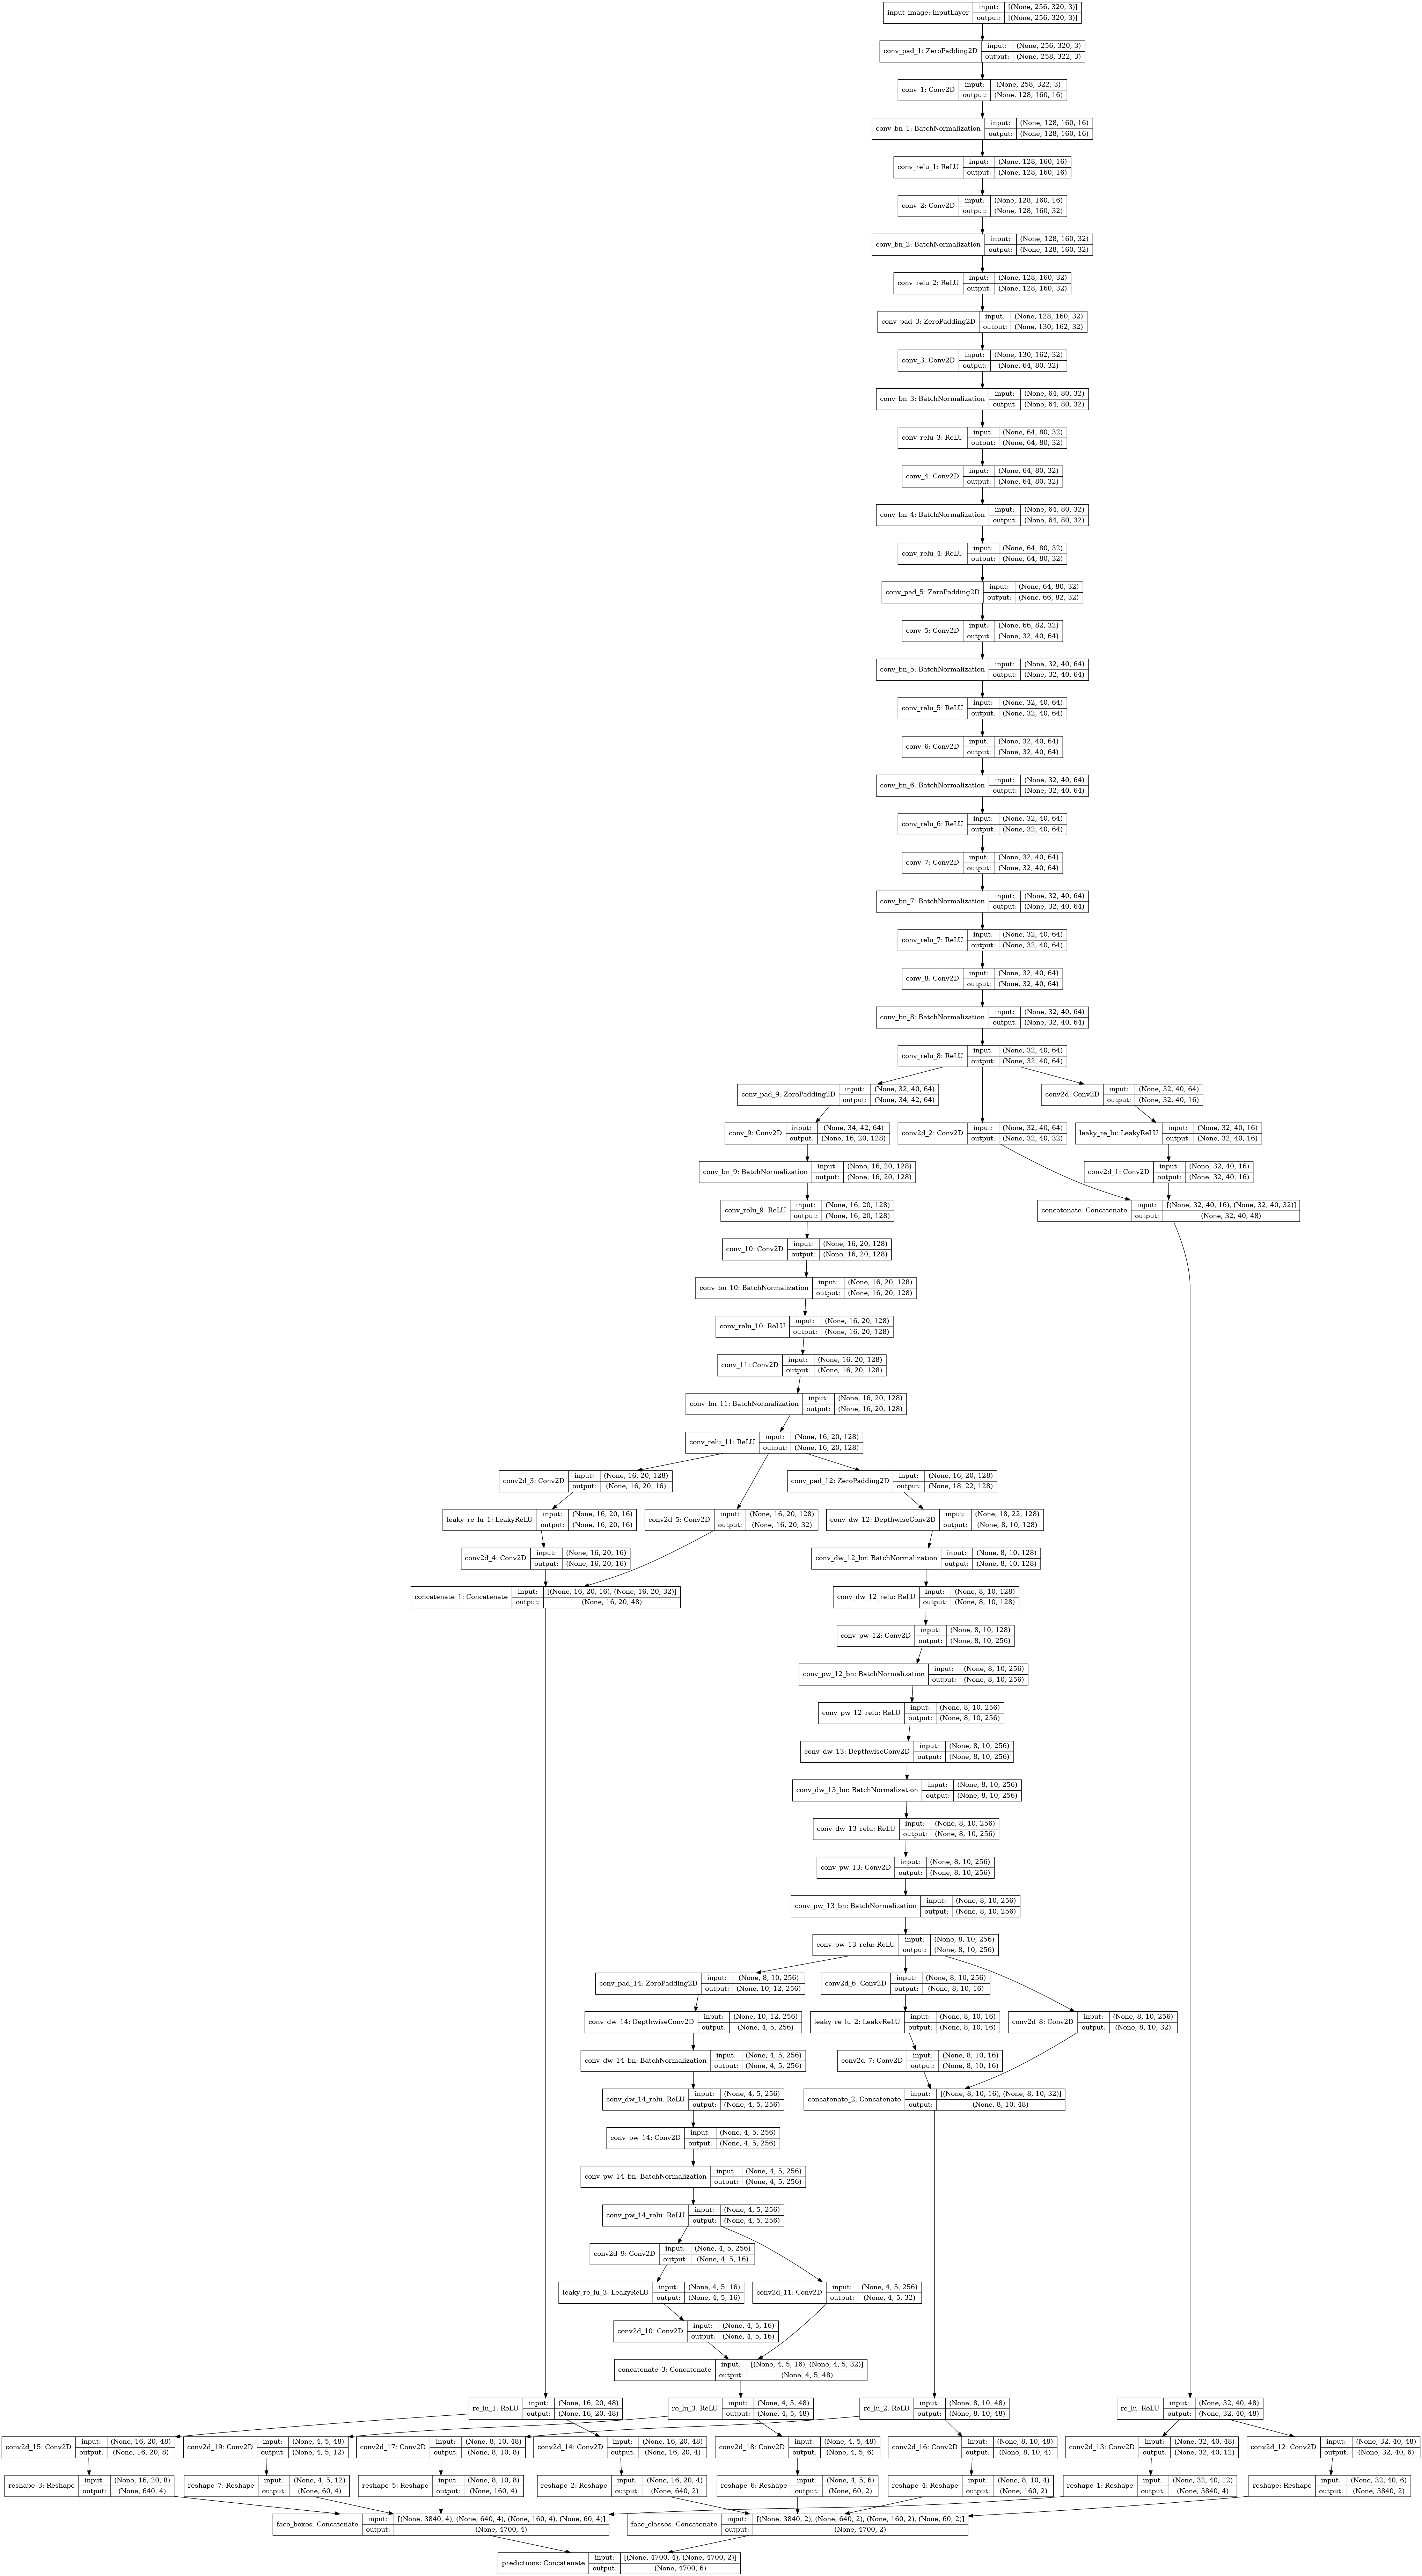

In [40]:
model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

## 모델 훈련 루프 정의

In [40]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])
        
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses, predictions

def val_step(inputs, labels):
    predictions = model.predict(inputs)
    val_losses = {}
    val_losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
    val_losses['loc'], val_losses['class'] = multi_loss(labels, predictions)
    val_total_loss = tf.add_n([l for l in val_losses.values()])
    return val_total_loss, val_losses, predictions

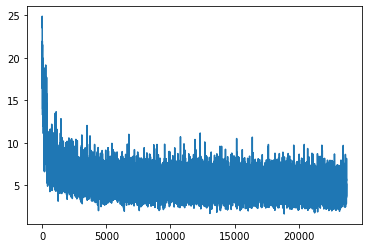

Epoch: 60/100 | Batch 19/402 | Batch time 0.081 || Loss: 4.435643 | loc loss:3.591637 | class loss:0.844006 

KeyboardInterrupt: 

In [35]:
%matplotlib inline
from IPython.display import clear_output

# SGD, 
# steps_per_epoch = DATASET_LEN // BATCH_SIZE
# learning_rate = MultiStepWarmUpLR(
#     initial_learning_rate=1e-2,
#     lr_steps=[e*steps_per_epoch for e in [50, 70]],
#     lr_rate=0.1,
#     warmup_steps=5*steps_per_epoch,
#     min_lr=1e-4
# )
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
# multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)
EPOCHS = 100
logs = {'total_loss':[]}
plt.show()
start = time.time()
for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        logs['total_loss'].append(total_loss)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        
        #graph plot
        if step % 50 == 0:
            clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
            plt.plot(logs['total_loss'])
            plt.show()
        
        #print result
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
end = time.time()
dur = end-start
print(f"duration: {dur:.4f}")
# 4.43은 너무 높은 것 같다 > loc, class loss 비중이 균형 x > 5000 iter만 해도 saturation 경향 확인
# IoU / AP 

## Full model 훈련 루프(train, val mean IoU 지표 확인 포함)

In [42]:
weight_list=[{'class_weight':1.0, 'box_weight':0.01},
{'class_weight':1.0, 'box_weight':0.05},
{'class_weight':1.0, 'box_weight':0.1},
{'class_weight':1.0, 'box_weight':0.2},
{'class_weight':1.0, 'box_weight':0.5},
{'class_weight':1.0, 'box_weight':1.0},
{'class_weight':1.0, 'box_weight':2.0},
{'class_weight':1.0, 'box_weight':5.0},
{'class_weight':1.0, 'box_weight':10.0}]


In [41]:
exam_basename = 'loss_weight'
EPOCHS = 20 # ✅epoch

for weight_idx in range(len(weight_list)):
    name = (f'{exam_basename}_{weight_list[weight_idx]}_{EPOCHS}epoch_sgd')
    print(f'exam name: {name}')
    if weight_idx > 0:
        del model

    model = SsdModel()
    #model.summary()
    tf.keras.utils.plot_model(
        model, 
        to_file=os.path.join(os.getcwd(), f'{name}_model.png'),
        show_shapes=True, 
        show_layer_names=True
    )

    steps_per_epoch = DATASET_LEN // BATCH_SIZE
    val_steps_per_epoch = DATASET_VAL_LEN // BATCH_SIZE

    learning_rate = MultiStepWarmUpLR(
        initial_learning_rate=1e-2,
        lr_steps=[e*steps_per_epoch for e in [50, 70]],
        lr_rate=0.1,
        warmup_steps=5*steps_per_epoch,
        min_lr=1e-4
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    multi_loss = WeightedMultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3, loss_weight=weight_list[weight_idx])
    @tf.function
    def train_step(inputs, labels):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training=True)
            losses = {}
            losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
            losses['loc'], losses['class'] = multi_loss(labels, predictions)
            total_loss = tf.add_n([l for l in losses.values()])

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return total_loss, losses, predictions

    def val_step(inputs, labels):
        predictions = model.predict(inputs)
        val_losses = {}
        val_losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        val_losses['loc'], val_losses['class'] = multi_loss(labels, predictions)
        val_total_loss = tf.add_n([l for l in val_losses.values()])
        return val_total_loss, val_losses, predictions
    %matplotlib inline
    # 3. 훈련
    logs = {'per_batch_total_loss':[],
            'per_batch_loc_loss':[],
            'per_batch_class_loss':[],
            'lr':[],
            'time':[],
            'per_epoch_total_loss':[],
            'per_epoch_loc_loss':[],
            'per_epoch_class_loss':[],
            'per_batch_mean_iou':[],
            'per_epoch_mean_iou':[]}

    val_logs = {'per_epoch_total_loss':[],
                'per_epoch_loc_loss':[],
                'per_epoch_class_loss':[],
                'per_epoch_mean_iou':[],
                'time':[]}


    start = time.time()
    for epoch in range(0, EPOCHS):
        # --EPOCH TRAINING--
        epoch_start = time.time()
        temp_epoch_train_total_losses = []
        temp_epoch_train_loc_losses = []
        temp_epoch_train_class_losses = []
        temp_batch_train_mean_iou = []
        for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
            load_t0 = time.time()
            total_loss, losses, predictions = train_step(inputs, labels)

            # --on_batch_end:log batch statistics--
            load_t1 = time.time()
            batch_time = load_t1 - load_t0
            accumulated_time = 0 if len(logs['time'])==0 else logs['time'][-1]
            logs['time'].append(accumulated_time+batch_time)
            # losses
            logs['per_batch_total_loss'].append(total_loss.numpy())
            logs['per_batch_loc_loss'].append(losses['loc'].numpy())
            logs['per_batch_class_loss'].append(losses['class'].numpy())
            logs['lr'].append(optimizer.learning_rate(step+ (epoch*len(train_dataset.take(steps_per_epoch)))).numpy())
            temp_epoch_train_total_losses.append(total_loss.numpy())
            temp_epoch_train_loc_losses.append(losses['loc'].numpy())
            temp_epoch_train_class_losses.append(losses['class'].numpy())
            # metric
            temp_sample_train_mean_iou = [] # log mean batch IoU  
            for sample_idx in range(inputs.shape[0]):
                pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(predictions[sample_idx], axis=0), boxes)
                decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
                temp_sample_train_mean_iou.append(mean_iou)
            temp_batch_train_mean_iou.append(np.mean(temp_sample_train_mean_iou))

            # --Visualize batch statistics
            if step % 100 == 0:
                clear_output(wait=True)  # ✅ 이전 출력 그래프를 지움 (Jupyter Notebook 전용)
                fig, axs = plt.subplots(6,3, figsize = (22, 50)) # 새로운 figure 생성
                fig.suptitle("Training statistics")
                #print('inputs_shape[0]', inputs.shape[0])
                for sample_idx in range(inputs.shape[0]):

                    pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(predictions[sample_idx], axis=0), boxes)
                    decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                    decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                    tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
                    print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}", end="", flush=True)

                    # plot train images
                    img_raw_i = np.array(inputs[sample_idx])
                    for box_index in range(len(pred_boxes)):
                        draw_box_on_face(img_raw_i, pred_boxes, pred_labels, pred_scores, box_index, IMAGE_LABELS)
                    for gt_box_index in range(len(decoded_true_labels)):
                        #print("decoded true labels", decoded_true_labels[:,:-1].numpy())
                        on_eval_draw_gt_box_on_face(img_raw_i, decoded_true_labels[:,:-1].numpy(), box_index=gt_box_index)
                    if sample_idx <12: #12 = 출력할 이미지 수
                        axs[2+sample_idx//3][sample_idx%3].imshow(np.clip(img_raw_i, 0, 1))
                        axs[2+sample_idx//3][sample_idx%3].set_ylabel('train images evaluation')
                    if sample_idx ==12:
                        break

                #batch losses
                axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
                axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
                axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
                axs[0][0].legend()
                axs[0][0].set_ylabel('batch total losses')
                #training informations
                axs[0][1].plot(logs['time'])
                axs[0][1].set_ylabel('total time(s)')
                axs[0][2].plot(logs['lr'])
                axs[0][2].set_ylabel('lr')
                #epoch losses
                axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
                axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
                axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
                axs[1][0].legend()
                axs[1][0].set_ylabel('epoch val losses')
                axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
                axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
                axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
                axs[1][1].legend()
                axs[1][1].set_ylabel('epoch training losses')
                #epoch metrics
                axs[1][2].plot(logs['per_epoch_mean_iou'], color='orange', label='epoch train mean IoU')
                axs[1][2].plot(val_logs['per_epoch_mean_iou'], color='green', label='epoch validation IoU')
                axs[1][2].legend()
                axs[1][2].set_ylabel('mean iou')

                plt.show()     

            # end batch training
            # print batch training result
            print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
        # --on_epoch_end:log epoch statistics--
        # log epoch training statistics
        epoch_end = time.time()
        logs['per_epoch_total_loss'].append(np.mean(temp_epoch_train_total_losses))
        logs['per_epoch_loc_loss'].append(np.mean(temp_epoch_train_loc_losses))
        logs['per_epoch_class_loss'].append(np.mean(temp_epoch_train_class_losses))
        logs['per_epoch_mean_iou'].append(np.mean(temp_batch_train_mean_iou))
        print("temp_epoch_train_total_losses", temp_epoch_train_total_losses)
        print("temp_epoch_train_mean_ious", logs['per_epoch_mean_iou'])

        # epoch validation
        epoch_val_start_time = time.time()
        temp_epoch_val_total_losses = []
        temp_epoch_val_loc_losses = []
        temp_epoch_val_class_losses = []
        temp_batch_val_mean_iou = []
        for step, (inputs, labels) in enumerate(val_dataset.take(val_steps_per_epoch)):
            val_total_loss, val_losses, val_predictions = val_step(inputs, labels)
            temp_epoch_val_total_losses.append(val_total_loss.numpy())
            temp_epoch_val_loc_losses.append(val_losses['loc'].numpy())
            temp_epoch_val_class_losses.append(val_losses['class'].numpy())

            temp_sample_val_mean_iou = []
            for sample_idx in range(inputs.shape[0]):

                pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(val_predictions[sample_idx], axis=0), boxes)
                decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
                print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}", end="", flush=True)
                temp_sample_val_mean_iou.append(mean_iou)
            temp_batch_val_mean_iou.append(np.mean(temp_sample_val_mean_iou))

            # plot
            if step % 100 == 0:
                clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
                fig, axs = plt.subplots(6,3, figsize = (22, 50))
                fig.suptitle("Training statistics")


                for sample_idx in range(inputs.shape[0]):
                    pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(val_predictions[sample_idx], axis=0), boxes)
                    decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                    decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                    tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
                    print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}", end="", flush=True)

                    img_raw_i = np.array(inputs[sample_idx])
                    for box_index in range(len(pred_boxes)):
                        draw_box_on_face(img_raw_i, pred_boxes, pred_labels, pred_scores, box_index, IMAGE_LABELS)
                    for gt_box_index in range(len(decoded_true_labels)):
                        #print("decoded true labels", decoded_true_labels[:,:-1].numpy())
                        on_eval_draw_gt_box_on_face(img_raw_i, decoded_true_labels[:,:-1].numpy(), box_index=gt_box_index)
                    if sample_idx <12:
                        axs[2+sample_idx//3][sample_idx%3].imshow(np.clip(img_raw_i, 0, 1))
                        axs[2+sample_idx//3][sample_idx%3].set_ylabel('validation images evaluation')
                    if sample_idx ==12:
                        break
                #batch losses
                axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
                axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
                axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
                axs[0][0].legend()
                axs[0][0].set_ylabel('batch total losses')
                #training informations
                axs[0][1].plot(logs['time'])
                axs[0][1].set_ylabel('total time(s)')
                axs[0][2].plot(logs['lr'])
                axs[0][2].set_ylabel('lr')
                #epoch losses
                axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
                axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
                axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
                axs[1][0].legend()
                axs[1][0].set_ylabel('epoch val losses')
                axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
                axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
                axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
                axs[1][1].legend()
                axs[1][1].set_ylabel('epoch training losses')
                #epoch metrics
                axs[1][2].plot(logs['per_epoch_mean_iou'], color='orange', label='epoch train mean IoU')
                axs[1][2].plot(val_logs['per_epoch_mean_iou'], color='green', label='epoch validation IoU')
                axs[1][2].legend()
                axs[1][2].set_ylabel('mean iou')

                plt.show()     

        # log epoch validation statistics
        epoch_val_end_time = time.time()
        epoch_val_time = epoch_val_end_time - epoch_val_start_time
        val_logs['time'].append(epoch_val_time)
        val_logs['per_epoch_total_loss'].append(np.mean(temp_epoch_val_total_losses))
        val_logs['per_epoch_loc_loss'].append(np.mean(temp_epoch_val_loc_losses))
        val_logs['per_epoch_class_loss'].append(np.mean(temp_epoch_val_class_losses))
        val_logs['per_epoch_mean_iou'].append(np.mean(temp_batch_val_mean_iou))



    #end training`
    end = time.time()
    dur = end-start
    print(f"duration: {dur:.4f}")

    #figure 저장
    fig.savefig(f'{name}_{dur:.0f}s.jpg')

    # 모델 저장 및 로드
    model.save(f"{name}.h5")  # 전체 모델 저장
    # model = tf.keras.models.load_model("sgd_60epoch.h5")

NameError: name 'weight_list' is not defined

## Class confusion matrix

In [60]:
weight_list=[{'class_weight':1.0, 'box_weight':0.5}]

tp,fp,fn:0,1,2 mean iou:0.0 mean giou:0.0, class_confusion_matrix:[[    0 10774]
 [14272     0]], class_confusion_matrix_by_far:[array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[    0, 30616],
       [43505,     0]]), array([[    0, 30642],
       [43370,     1]])]tp,fp,fn:0,1,6 mean iou:0.0 mean giou:0.0, class_confusion_matrix:[[    0 10774]
 [14272     0]], class_confusion_matrix_by_far:[array([

       [43370,     1]])]tp,fp,fn:0,23,35 mean iou:0.0 mean giou:0.0, class_confusion_matrix:[[    0 10774]
 [14272     0]], class_confusion_matrix_by_far:[array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]]), array([[    0, 30616],
       [43505,     0]]), array([[    0, 30642],
       [43370,     1]])]tp,fp,fn:1,0,0 mean iou:0.6115235545185226 mean giou:0.6038601398468018, class_confusion_matrix:[[    0 10774]

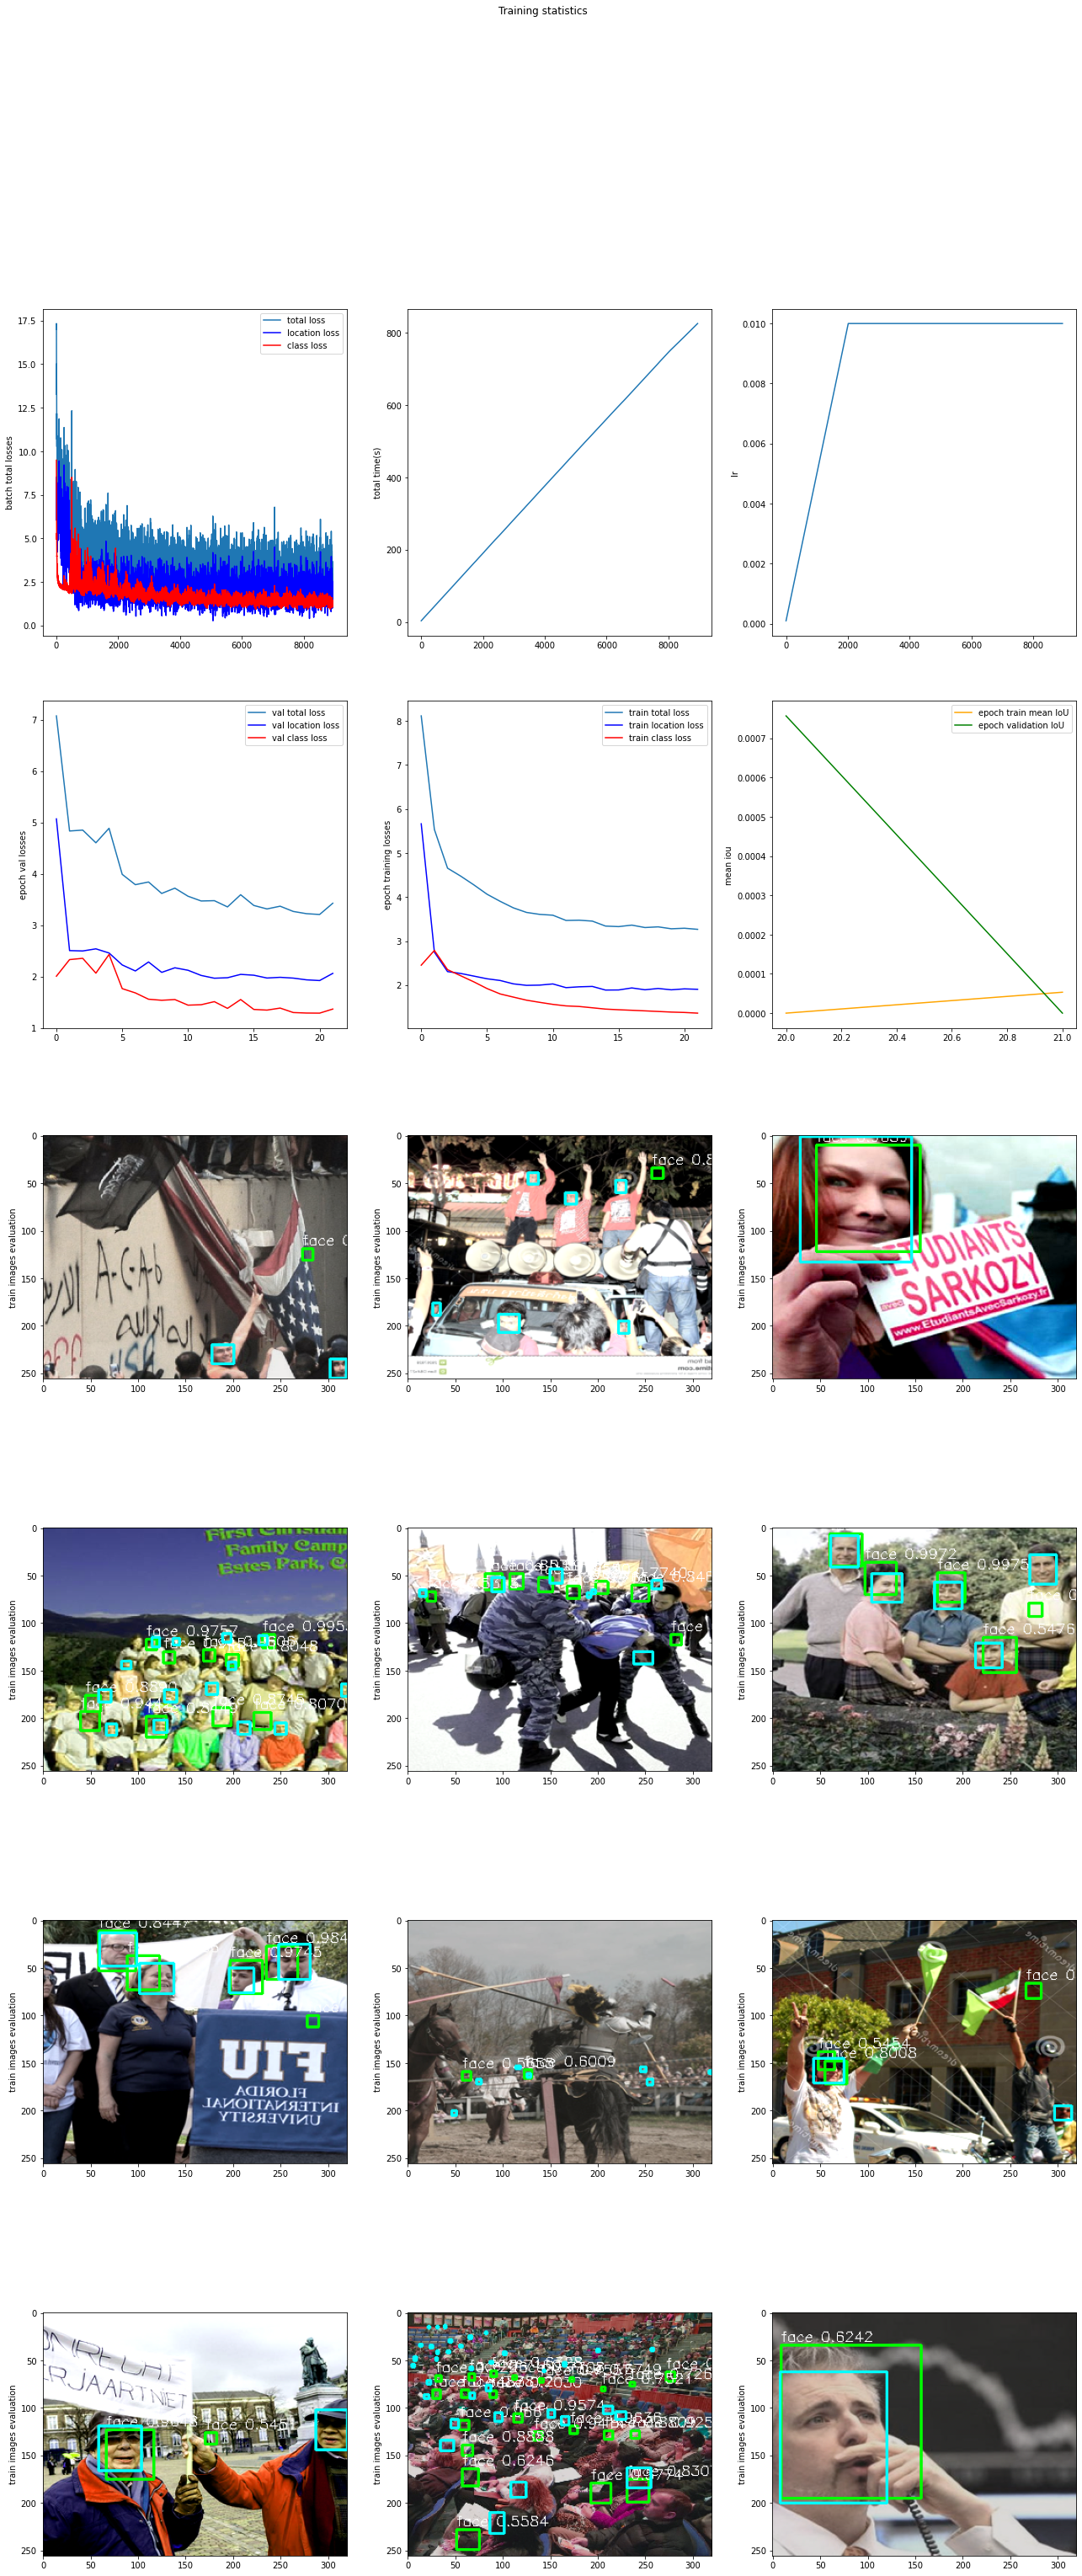

Epoch: 23/60 | Batch 144/402 | Batch time 0.083 || Loss: 2.886781 | loc loss:1.461668 | class loss:1.425113 

In [ ]:
exam_basename = 'class_confusion_matrix'
EPOCHS = 60 # ✅epoch

for weight_idx in range(len(weight_list)):
    name = (f'{exam_basename}_{weight_list[weight_idx]}_{EPOCHS}epoch_sgd')
    print(f'exam name: {name}')
    if weight_idx > 0:
        del model

    model = SsdModel()
    #model.summary()
    tf.keras.utils.plot_model(
        model, 
        to_file=os.path.join(os.getcwd(), f'{name}_model.png'),
        show_shapes=True, 
        show_layer_names=True
    )

    steps_per_epoch = DATASET_LEN // BATCH_SIZE
    val_steps_per_epoch = DATASET_VAL_LEN // BATCH_SIZE

    learning_rate = MultiStepWarmUpLR(
        initial_learning_rate=1e-2,
        lr_steps=[e*steps_per_epoch for e in [50, 70]],
        lr_rate=0.1,
        warmup_steps=5*steps_per_epoch,
        min_lr=1e-4
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    multi_loss = WeightedMultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3, loss_weight=weight_list[weight_idx])
    @tf.function
    def train_step(inputs, labels):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training=True)
            losses = {}
            losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
            losses['loc'], losses['class'] = multi_loss(labels, predictions)
            total_loss = tf.add_n([l for l in losses.values()])

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return total_loss, losses, predictions

    def val_step(inputs, labels):
        predictions = model.predict(inputs)
        val_losses = {}
        val_losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        val_losses['loc'], val_losses['class'] = multi_loss(labels, predictions)
        val_total_loss = tf.add_n([l for l in val_losses.values()])
        return val_total_loss, val_losses, predictions
    %matplotlib inline
    # 3. 훈련
    logs = {'per_batch_total_loss':[],
            'per_batch_loc_loss':[],
            'per_batch_class_loss':[],
            'lr':[],
            'time':[],
            'per_epoch_total_loss':[],
            'per_epoch_loc_loss':[],
            'per_epoch_class_loss':[],
            'per_batch_mean_iou':[],
            'per_epoch_mean_iou':[],
            'loc_confusion_matrix':[],
            'cls_confusion_matrix':[]}

    val_logs = {'per_epoch_total_loss':[],
                'per_epoch_loc_loss':[],
                'per_epoch_class_loss':[],
                'per_epoch_mean_iou':[],
                'time':[],
                'loc_confusion_matrix':[],
                'cls_confusion_matrix':[]}


    start = time.time()
    for epoch in range(0, EPOCHS):
        # --EPOCH TRAINING--
        epoch_start = time.time()
        temp_epoch_train_total_losses = []
        temp_epoch_train_loc_losses = []
        temp_epoch_train_class_losses = []
        temp_batch_train_mean_iou = []
        temp_train_confusion_matrix = np.zeros((2, 2), dtype=int)
        for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
            load_t0 = time.time()
            total_loss, losses, predictions = train_step(inputs, labels)

            # --on_batch_end:log batch statistics--
            load_t1 = time.time()
            batch_time = load_t1 - load_t0
            accumulated_time = 0 if len(logs['time'])==0 else logs['time'][-1]
            logs['time'].append(accumulated_time+batch_time)
            # losses
            logs['per_batch_total_loss'].append(total_loss.numpy())
            logs['per_batch_loc_loss'].append(losses['loc'].numpy())
            logs['per_batch_class_loss'].append(losses['class'].numpy())
            logs['lr'].append(optimizer.learning_rate(step+ (epoch*len(train_dataset.take(steps_per_epoch)))).numpy())
            temp_epoch_train_total_losses.append(total_loss.numpy())
            temp_epoch_train_loc_losses.append(losses['loc'].numpy())
            temp_epoch_train_class_losses.append(losses['class'].numpy())
            # metric
            temp_sample_train_mean_iou = [] # log mean batch IoU  
            
            if epoch > 19:
                for sample_idx in range(inputs.shape[0]):
                    pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(predictions[sample_idx], axis=0), boxes)
                    decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                    decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                    tp, fp, fn, mean_iou, mean_giou, temp_train_confusion_matrix = evaluate_detections_with_conf_mat(
                        decoded_true_labels.numpy(), 
                        tf.concat([pred_boxes, tf.expand_dims(pred_labels, axis=1)], axis=1), 
                        IMAGE_WIDTH, 
                        IMAGE_HEIGHT, 
                        iou_threshold=0.5, 
                        class_confusion_mat=temp_train_confusion_matrix)
                    temp_sample_train_mean_iou.append(mean_iou)
                temp_batch_train_mean_iou.append(np.mean(temp_sample_train_mean_iou))
            
            # --Visualize batch statistics
            if step % 100 == 0:
                clear_output(wait=True)  # ✅ 이전 출력 그래프를 지움 (Jupyter Notebook 전용)
                fig, axs = plt.subplots(6,3, figsize = (22, 50)) # 새로운 figure 생성
                fig.suptitle("Training statistics")
                #print('inputs_shape[0]', inputs.shape[0])
                for sample_idx in range(inputs.shape[0]):

                    pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(predictions[sample_idx], axis=0), boxes)
                    decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                    decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                    tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
                    print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}, class_confusion_matrix:{temp_train_confusion_matrix}, class_confusion_matrix_by_far:{logs['cls_confusion_matrix']}", end="", flush=True)

                    # plot train images
                    img_raw_i = np.array(inputs[sample_idx])
                    for box_index in range(len(pred_boxes)):
                        draw_box_on_face(img_raw_i, pred_boxes, pred_labels, pred_scores, box_index, IMAGE_LABELS)
                    for gt_box_index in range(len(decoded_true_labels)):
                        #print("decoded true labels", decoded_true_labels[:,:-1].numpy())
                        on_eval_draw_gt_box_on_face(img_raw_i, decoded_true_labels[:,:-1].numpy(), box_index=gt_box_index)
                    if sample_idx <12: #12 = 출력할 이미지 수
                        axs[2+sample_idx//3][sample_idx%3].imshow(np.clip(img_raw_i, 0, 1))
                        axs[2+sample_idx//3][sample_idx%3].set_ylabel('train images evaluation')
                    if sample_idx ==12:
                        break

                #batch losses
                axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
                axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
                axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
                axs[0][0].legend()
                axs[0][0].set_ylabel('batch total losses')
                #training informations
                axs[0][1].plot(logs['time'])
                axs[0][1].set_ylabel('total time(s)')
                axs[0][2].plot(logs['lr'])
                axs[0][2].set_ylabel('lr')
                #epoch losses
                axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
                axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
                axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
                axs[1][0].legend()
                axs[1][0].set_ylabel('epoch val losses')
                axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
                axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
                axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
                axs[1][1].legend()
                axs[1][1].set_ylabel('epoch training losses')
                #epoch metrics
                axs[1][2].plot(logs['per_epoch_mean_iou'], color='orange', label='epoch train mean IoU')
                axs[1][2].plot(val_logs['per_epoch_mean_iou'], color='green', label='epoch validation IoU')
                axs[1][2].legend()
                axs[1][2].set_ylabel('mean iou')

                plt.show()     

            # end batch training
            # print batch training result
            print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
        # --on_epoch_end:log epoch statistics--
        # log epoch training statistics
        epoch_end = time.time()
        logs['per_epoch_total_loss'].append(np.mean(temp_epoch_train_total_losses))
        logs['per_epoch_loc_loss'].append(np.mean(temp_epoch_train_loc_losses))
        logs['per_epoch_class_loss'].append(np.mean(temp_epoch_train_class_losses))
        logs['per_epoch_mean_iou'].append(np.mean(temp_batch_train_mean_iou))
        logs['cls_confusion_matrix'].append(temp_train_confusion_matrix)
        print("temp_epoch_train_total_losses", temp_epoch_train_total_losses)
        print("temp_epoch_train_mean_ious", logs['per_epoch_mean_iou'])

        # epoch validation
        epoch_val_start_time = time.time()
        temp_epoch_val_total_losses = []
        temp_epoch_val_loc_losses = []
        temp_epoch_val_class_losses = []
        temp_batch_val_mean_iou = []
        temp_val_confusion_matrix = np.zeros((2, 2), dtype=int)
        
        for step, (inputs, labels) in enumerate(val_dataset.take(val_steps_per_epoch)):
            val_total_loss, val_losses, val_predictions = val_step(inputs, labels)
            temp_epoch_val_total_losses.append(val_total_loss.numpy())
            temp_epoch_val_loc_losses.append(val_losses['loc'].numpy())
            temp_epoch_val_class_losses.append(val_losses['class'].numpy())

            temp_sample_val_mean_iou = []
            if epoch > 19:
                for sample_idx in range(inputs.shape[0]):

                    pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(val_predictions[sample_idx], axis=0), boxes)
                    decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                    decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                    tp, fp, fn, mean_iou, mean_giou, temp_val_confusion_matrix = evaluate_detections_with_conf_mat(
                        decoded_true_labels.numpy(), 
                        tf.concat([pred_boxes, tf.expand_dims(pred_labels, axis=1)],axis=1),
                        IMAGE_WIDTH, 
                        IMAGE_HEIGHT, 
                        iou_threshold=0.5, 
                        class_confusion_mat=temp_val_confusion_matrix)
                    print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}, class_confusion_matrix:{temp_val_confusion_matrix},class_confusion_matrix_by_far:{val_logs['cls_confusion_matrix']}", end="", flush=True)
                    temp_sample_val_mean_iou.append(mean_iou)
                temp_batch_val_mean_iou.append(np.mean(temp_sample_val_mean_iou))

            # plot
            if step % 100 == 0:
                clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
                fig, axs = plt.subplots(6,3, figsize = (22, 50))
                fig.suptitle("Training statistics")


                for sample_idx in range(inputs.shape[0]):
                    pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(val_predictions[sample_idx], axis=0), boxes)
                    decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                    decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                    tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
                    print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}, class_confusion_matrix:{temp_val_confusion_matrix}", end="", flush=True)

                    img_raw_i = np.array(inputs[sample_idx])
                    for box_index in range(len(pred_boxes)):
                        draw_box_on_face(img_raw_i, pred_boxes, pred_labels, pred_scores, box_index, IMAGE_LABELS)
                    for gt_box_index in range(len(decoded_true_labels)):
                        #print("decoded true labels", decoded_true_labels[:,:-1].numpy())
                        on_eval_draw_gt_box_on_face(img_raw_i, decoded_true_labels[:,:-1].numpy(), box_index=gt_box_index)
                    if sample_idx <12:
                        axs[2+sample_idx//3][sample_idx%3].imshow(np.clip(img_raw_i, 0, 1))
                        axs[2+sample_idx//3][sample_idx%3].set_ylabel('validation images evaluation')
                    if sample_idx ==12:
                        break
                #batch losses
                axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
                axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
                axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
                axs[0][0].legend()
                axs[0][0].set_ylabel('batch total losses')
                #training informations
                axs[0][1].plot(logs['time'])
                axs[0][1].set_ylabel('total time(s)')
                axs[0][2].plot(logs['lr'])
                axs[0][2].set_ylabel('lr')
                #epoch losses
                axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
                axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
                axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
                axs[1][0].legend()
                axs[1][0].set_ylabel('epoch val losses')
                axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
                axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
                axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
                axs[1][1].legend()
                axs[1][1].set_ylabel('epoch training losses')
                #epoch metrics
                axs[1][2].plot(logs['per_epoch_mean_iou'], color='orange', label='epoch train mean IoU')
                axs[1][2].plot(val_logs['per_epoch_mean_iou'], color='green', label='epoch validation IoU')
                axs[1][2].legend()
                axs[1][2].set_ylabel('mean iou')

                plt.show()     

        # log epoch validation statistics
        epoch_val_end_time = time.time()
        epoch_val_time = epoch_val_end_time - epoch_val_start_time
        val_logs['time'].append(epoch_val_time)
        val_logs['per_epoch_total_loss'].append(np.mean(temp_epoch_val_total_losses))
        val_logs['per_epoch_loc_loss'].append(np.mean(temp_epoch_val_loc_losses))
        val_logs['per_epoch_class_loss'].append(np.mean(temp_epoch_val_class_losses))
        val_logs['per_epoch_mean_iou'].append(np.mean(temp_batch_val_mean_iou))
        val_logs['cls_confusion_matrix'].append(temp_val_confusion_matrix)


    #end training`
    end = time.time()
    dur = end-start
    print(f"duration: {dur:.4f}")

    #figure 저장
    fig.savefig(f'{name}_{dur:.0f}s.jpg')

    # 모델 저장 및 로드
    model.save(f"{name}.h5")  # 전체 모델 저장
    # model = tf.keras.models.load_model("sgd_60epoch.h5")

In [ ]:
%matplotlib inline
# 3. 훈련
EPOCHS = 10 # ✅epoch
logs = {'per_batch_total_loss':[],
        'per_batch_loc_loss':[],
        'per_batch_class_loss':[],
        'lr':[],
        'time':[],
        'per_epoch_total_loss':[],
        'per_epoch_loc_loss':[],
        'per_epoch_class_loss':[],
        'per_batch_mean_iou':[],
        'per_epoch_mean_iou':[]}

val_logs = {'per_epoch_total_loss':[],
            'per_epoch_loc_loss':[],
            'per_epoch_class_loss':[],
            'time':[]}


start = time.time()
for epoch in range(0, EPOCHS):
    # --EPOCH TRAINING--
    epoch_start = time.time()
    temp_epoch_train_total_losses = []
    temp_epoch_train_loc_losses = []
    temp_epoch_train_class_losses = []
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses, predictions = train_step(inputs, labels)
        
        # --log batch statistics--
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        accumulated_time = 0 if len(logs['time'])==0 else logs['time'][-1]
        logs['time'].append(accumulated_time+batch_time)
        logs['per_batch_total_loss'].append(total_loss.numpy())
        logs['per_batch_loc_loss'].append(losses['loc'].numpy())
        logs['per_batch_class_loss'].append(losses['class'].numpy())
        logs['lr'].append(optimizer.learning_rate(step+ (epoch*len(train_dataset.take(steps_per_epoch)))).numpy())
        temp_epoch_train_total_losses.append(total_loss.numpy())
        temp_epoch_train_loc_losses.append(losses['loc'].numpy())
        temp_epoch_train_class_losses.append(losses['class'].numpy())
           
        # --Visualize batch statistics
        if step % 100 == 0:
            clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
            fig, axs = plt.subplots(11,3, figsize = (22, 80))

            #print('inputs_shape[0]', inputs.shape[0])
            for sample_idx in range(inputs.shape[0]):

                pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(predictions[sample_idx], axis=0), boxes)
                decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
                print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}", tp, fp, fn, mean_iou, mean_giou)

                #graph plot
                img_raw_i = np.array(inputs[sample_idx])
                for box_index in range(len(pred_boxes)):
                    draw_box_on_face(img_raw_i, pred_boxes, pred_labels, pred_scores, box_index, IMAGE_LABELS)
                for gt_box_index in range(len(decoded_true_labels)):
                    #print("decoded true labels", decoded_true_labels[:,:-1].numpy())
                    on_eval_draw_gt_box_on_face(img_raw_i, decoded_true_labels[:,:-1].numpy(), box_index=gt_box_index)
                if sample_idx <12:
                    axs[2+sample_idx//3][sample_idx%3].imshow(np.clip(img_raw_i, 0, 1) )

                if sample_idx==inputs.shape[0]-1 and step % 50 == 0:
                    axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
                    axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
                    axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
                    axs[0][0].legend()
                    axs[0][0].set_ylabel('batch total losses')
                    axs[0][1].plot(logs['time'])
                    axs[0][1].set_ylabel('total time(s)')
                    axs[0][2].plot(logs['lr'])
                    axs[0][2].set_ylabel('lr')
                    axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
                    axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
                    axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
                    axs[1][0].legend()
                    axs[1][0].set_ylabel('epoch val losses')
                    axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
                    axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
                    axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
                    axs[1][1].legend()
                    axs[1][1].set_ylabel('epoch training losses')
                    axs[1][2].plot(val_logs['time'], label='validation time')
                    axs[1][2].legend()
                    axs[1][2].set_ylabel('total val time(s)')

            plt.show()     

        # end batch training
        # print batch training result
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
    # end epoch training
    # log epoch training statistics
    epoch_end = time.time()
    logs['per_epoch_total_loss'].append(np.mean(temp_epoch_train_total_losses))
    logs['per_epoch_loc_loss'].append(np.mean(temp_epoch_train_loc_losses))
    logs['per_epoch_class_loss'].append(np.mean(temp_epoch_train_class_losses))
    print("temp_epoch_train_total_losses", temp_epoch_train_total_losses)

    # epoch validation
    epoch_val_start_time = time.time()
    temp_epoch_val_total_losses = []
    temp_epoch_val_loc_losses = []
    temp_epoch_val_class_losses = []
    for step, (inputs, labels) in enumerate(val_dataset.take(val_steps_per_epoch)):
        val_total_loss, val_losses, val_predictions = val_step(inputs, labels)
        temp_epoch_val_total_losses.append(val_total_loss.numpy())
        temp_epoch_val_loc_losses.append(val_losses['loc'].numpy())
        temp_epoch_val_class_losses.append(val_losses['class'].numpy())
        
        # end epoch validation    

        
        clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
        fig, axs = plt.subplots(11,3, figsize = (22, 80))

        #print('inputs_shape[0]', inputs.shape[0])
        for sample_idx in range(inputs.shape[0]):

            pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(predictions[sample_idx], axis=0), boxes)
            decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
            decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

            tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
            print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}", tp, fp, fn, mean_iou, mean_giou)

            #graph plot
            img_raw_i = np.array(inputs[sample_idx])
            for box_index in range(len(pred_boxes)):
                draw_box_on_face(img_raw_i, pred_boxes, pred_labels, pred_scores, box_index, IMAGE_LABELS)
            for gt_box_index in range(len(decoded_true_labels)):
                #print("decoded true labels", decoded_true_labels[:,:-1].numpy())
                on_eval_draw_gt_box_on_face(img_raw_i, decoded_true_labels[:,:-1].numpy(), box_index=gt_box_index)
            if sample_idx <12:
                axs[2+sample_idx//3][sample_idx%3].imshow(np.clip(img_raw_i, 0, 1) )
        
        
        
        
        
    # log epoch validation statistics
    epoch_val_end_time = time.time()
    epoch_val_time = epoch_val_end_time - epoch_val_start_time
    val_logs['time'].append(epoch_val_time)
    val_logs['per_epoch_total_loss'].append(np.mean(temp_epoch_val_total_losses))
    val_logs['per_epoch_loc_loss'].append(np.mean(temp_epoch_val_loc_losses))
    val_logs['per_epoch_class_loss'].append(np.mean(temp_epoch_val_class_losses))

    # epoch validation graph plot
    clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
    fig, axs = plt.subplots(2,3, figsize = (22, 16))
    axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
    axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
    axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
    axs[0][0].legend()
    axs[0][0].set_ylabel('batch total losses')
    axs[0][1].plot(logs['time'])
    axs[0][1].set_ylabel('total time(s)')
    axs[0][2].plot(logs['lr'])
    axs[0][2].set_ylabel('lr')
    axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
    axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
    axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
    axs[1][0].legend()
    axs[1][0].set_ylabel('epoch val losses')
    axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
    axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
    axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
    axs[1][1].legend()
    axs[1][1].set_ylabel('epoch training losses')
    axs[1][2].plot(val_logs['time'], label='validation time')
    axs[1][2].legend()
    axs[1][2].set_ylabel('total val time(s)')

    plt.show()
    
    

#end training`
end = time.time()
dur = end-start
print(f"duration: {dur:.4f}")

#figure 저장
fig.suptitle("Batch training statistics")
plt.show()
fig.savefig(f'{exam_basename}_{EPOCHS}epoch_sgd_{dur:.0f}s.jpg')

# 모델 저장 및 로드
# model.save("sgd_60epoch.h5")  # 전체 모델 저장
# model = tf.keras.models.load_model("sgd_60epoch.h5")

In [38]:
model.save("sgd_60epoch.h5")  # 전체 모델 저장
model = tf.keras.models.load_model("sgd_60epoch.h5") # 모델 로드

In [73]:
!pwd

/aiffel/aiffel/face_detector


## 실험
1. 수렴 여부 확인
    - 수렴에 소요되는 시간 단축
    - 오버피팅, 언더피팅 확인용 메트릭(IoU)
        - 실패 사례 개선
2. loss항별 최적 가중치 탐색
3. 최적 NMS threshold 탐색
4. 백본 모델 비교

- lr을 2배로 높였을 때

10epoch_sgd_1276s


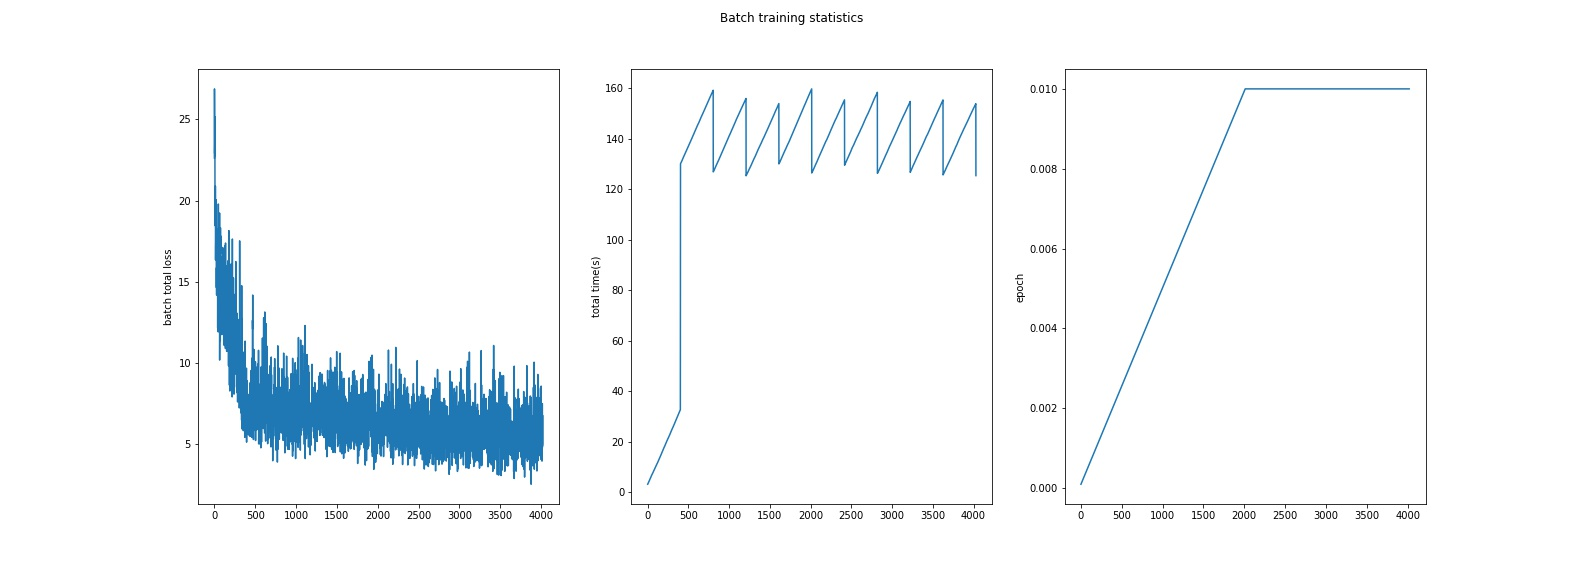

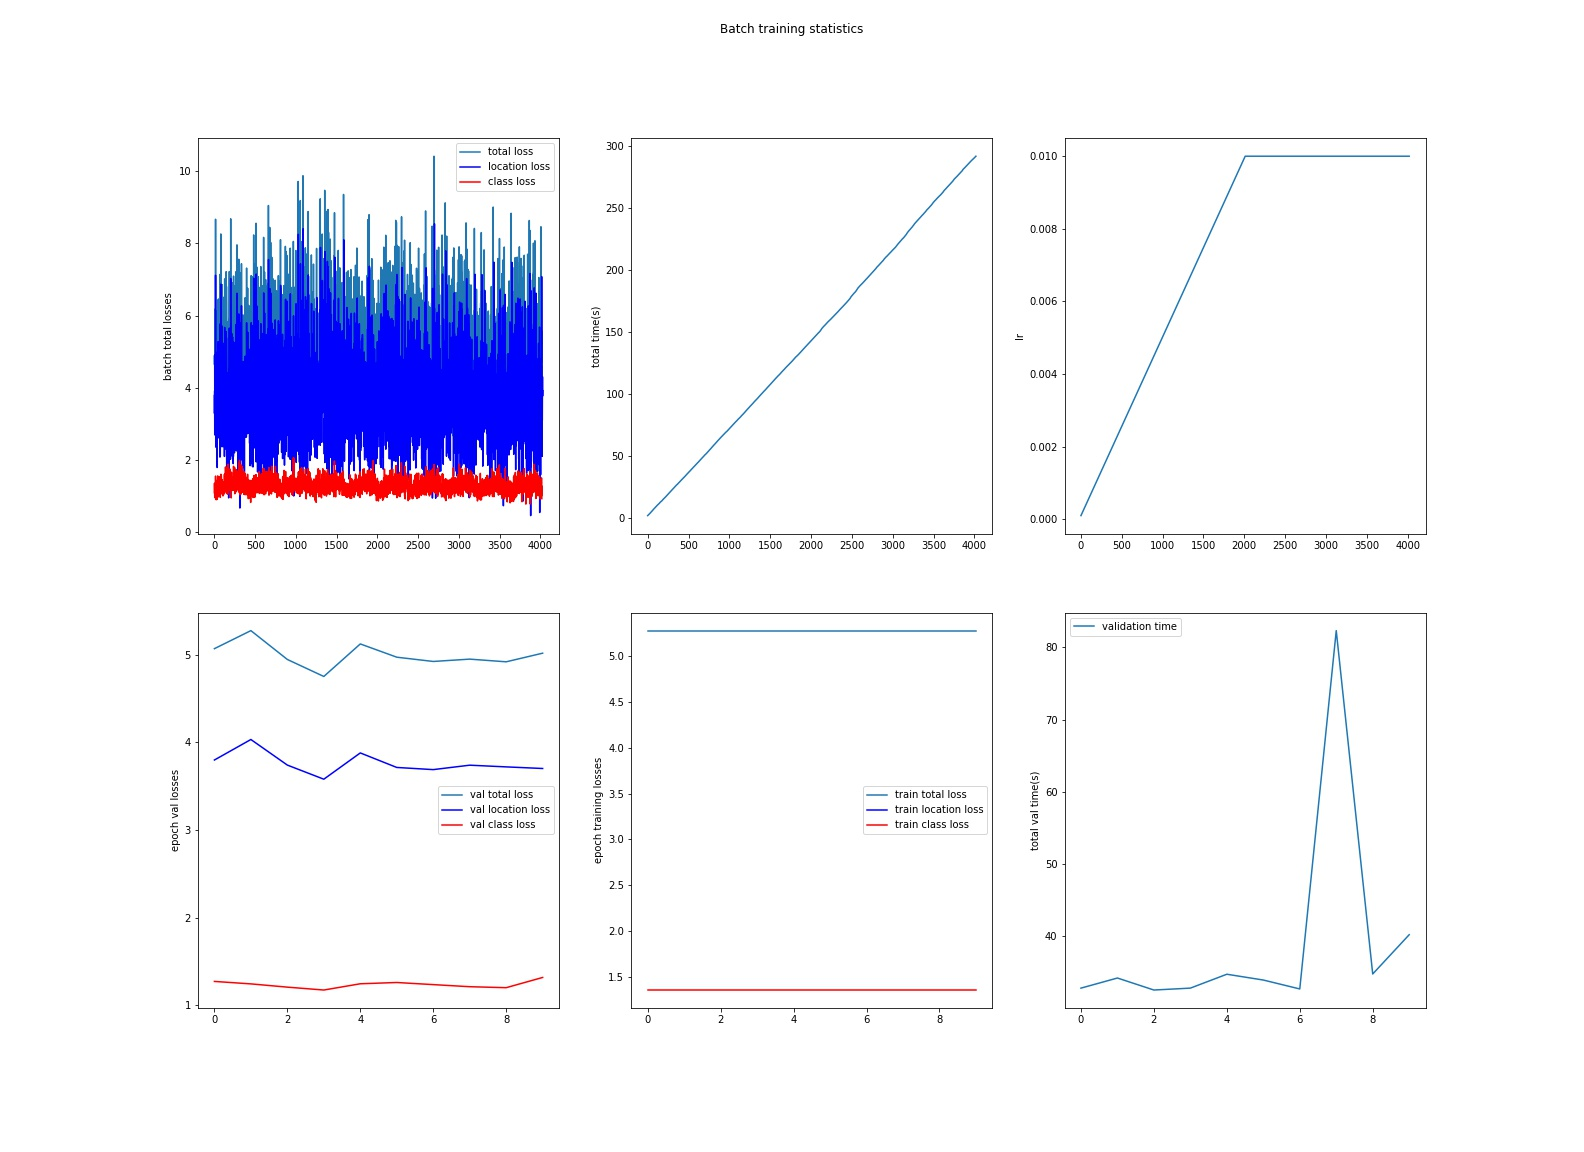

In [38]:
from IPython.display import Image, display
print("10epoch_sgd_1276s")
display(Image(filename="10epoch_sgd_1276s.jpg"))
display(Image(filename="lr_metric_10epoch_sgd_1766s.jpg"))



In [65]:
# del model # 이미 모델 객체가 있을 경우 메모리 확보를 위해서 주석 제거 후 실행 

In [39]:
%matplotlib inline
from IPython.display import clear_output
# 실험 일반 설정
exam_basename = "lr_metric" # ✅ 테스트명

# 1. model compile
model = SsdModel() # ✅ model 종류
#model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), f'{exam_basename}.png'),
    show_shapes=True, 
    show_layer_names=True
)

# 2. lr 설정, lr scheduler, optimizer, loss criterion 설정
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
) #✅LR schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True) #✅Optimizer

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3) #✅loss configuration

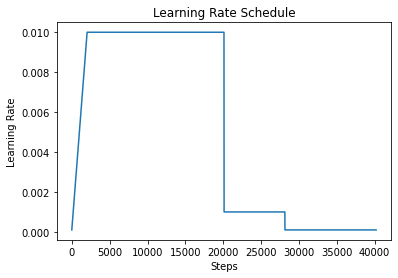

In [40]:
#lr schedule

steps = np.arange(0, 100 * steps_per_epoch, dtype=np.float32)
lrs = [optimizer.learning_rate(step).numpy() for step in steps]

plt.plot(steps, lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

In [60]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])
        
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses, predictions

def val_step(inputs, labels):
    predictions = model.predict(inputs)
    val_losses = {}
    val_losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
    val_losses['loc'], val_losses['class'] = multi_loss(labels, predictions)
    val_total_loss = tf.add_n([l for l in val_losses.values()])
    return val_total_loss, val_losses, predictions

In [ ]:
%matplotlib inline
# 3. 훈련
EPOCHS = 10 # ✅epoch
logs = {'per_batch_total_loss':[],
        'per_batch_loc_loss':[],
        'per_batch_class_loss':[],
        'lr':[],
        'time':[],
        'per_epoch_total_loss':[],
        'per_epoch_loc_loss':[],
        'per_epoch_class_loss':[],
        'per_batch_mean_iou':[],
        'per_epoch_mean_iou':[]}

val_logs = {'per_epoch_total_loss':[],
            'per_epoch_loc_loss':[],
            'per_epoch_class_loss':[],
            'time':[]}

start = time.time()
for epoch in range(0, EPOCHS):
    # epoch training 
    epoch_start = time.time()
    temp_epoch_train_total_losses = []
    temp_epoch_train_loc_losses = []
    temp_epoch_train_class_losses = []
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses, predictions = train_step(inputs, labels)
        
        #log batch statistics
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        accumulated_time = 0 if len(logs['time'])==0 else logs['time'][-1]
        logs['time'].append(accumulated_time+batch_time)
        logs['per_batch_total_loss'].append(total_loss.numpy())
        logs['per_batch_loc_loss'].append(losses['loc'].numpy())
        logs['per_batch_class_loss'].append(losses['class'].numpy())
        logs['lr'].append(optimizer.learning_rate(step+ (epoch*len(train_dataset.take(steps_per_epoch)))).numpy())
        temp_epoch_train_total_losses.append(total_loss.numpy())
        temp_epoch_train_loc_losses.append(losses['loc'].numpy())
        temp_epoch_train_class_losses.append(losses['class'].numpy())
           
        #log batch statistics
        if step % 50 == 0:
            clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
            fig, axs = plt.subplots(11,3, figsize = (22, 40))

            #print('inputs_shape[0]', inputs.shape[0])
            for sample_idx in range(inputs.shape[0]):

                pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(predictions[sample_idx], axis=0), boxes)
                decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
                decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

                tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
                print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}", tp, fp, fn, mean_iou, mean_giou)

                # batch graph plot
                img_raw_i = np.array(inputs[sample_idx])
                for box_index in range(len(pred_boxes)):
                    draw_box_on_face(img_raw_i, pred_boxes, pred_labels, pred_scores, box_index, IMAGE_LABELS)
                for gt_box_index in range(len(decoded_true_labels)):
                    #print("decoded true labels", decoded_true_labels[:,:-1].numpy())
                    on_eval_draw_gt_box_on_face(img_raw_i, decoded_true_labels[:,:-1].numpy(), box_index=gt_box_index)
                if sample_idx <12:
                    axs[3+sample_idx//3][sample_idx%3].imshow(np.clip(img_raw_i, 0, 1) )

                if sample_idx==inputs.shape[0]-1 and step % 50 == 0:
                    axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
                    axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
                    axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
                    axs[0][0].legend()
                    axs[0][0].set_ylabel('batch total losses')
                    axs[0][1].plot(logs['time'])
                    axs[0][1].set_ylabel('total time(s)')
                    axs[0][2].plot(logs['lr'])
                    axs[0][2].set_ylabel('lr')
                    axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
                    axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
                    axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
                    axs[1][0].legend()
                    axs[1][0].set_ylabel('epoch val losses')
                    axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
                    axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
                    axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
                    axs[1][1].legend()
                    axs[1][1].set_ylabel('epoch training losses')
                    axs[1][2].plot(val_logs['time'], label='validation time')
                    axs[1][2].legend()
                    axs[1][2].set_ylabel('total val time(s)')

            plt.show()     
          

        # plt.show()
        # end batch training
        # print batch training result
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
    # end epoch training
    # log epoch training statistics
    epoch_end = time.time()
    logs['per_epoch_total_loss'].append(np.mean(temp_epoch_train_total_losses))
    logs['per_epoch_loc_loss'].append(np.mean(temp_epoch_train_loc_losses))
    logs['per_epoch_class_loss'].append(np.mean(temp_epoch_train_class_losses))
    print("temp_epoch_train_total_losses", temp_epoch_train_total_losses)

    # epoch validation
    epoch_val_start_time = time.time()
    temp_epoch_val_total_losses = []
    temp_epoch_val_loc_losses = []
    temp_epoch_val_class_losses = []
    for step, (inputs, labels) in enumerate(val_dataset.take(val_steps_per_epoch)):
        val_total_loss, val_losses, val_predictions = val_step(inputs, labels)
        temp_epoch_val_total_losses.append(val_total_loss.numpy())
        temp_epoch_val_loc_losses.append(val_losses['loc'].numpy())
        temp_epoch_val_class_losses.append(val_losses['class'].numpy())
        
        # end epoch validation    
        clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
        fig, axs = plt.subplots(11,3, figsize = (22, 40))

        #print('inputs_shape[0]', inputs.shape[0])
        for sample_idx in range(inputs.shape[0]):

            pred_boxes, pred_labels, pred_scores = parse_predict(np.expand_dims(val_predictions[sample_idx], axis=0), boxes)
            decoded_gt_boxes = tf.concat([decode_bbox_tf(labels[sample_idx][:,:-1], boxes), labels[sample_idx][:,-1:]], axis=1)
            decoded_true_labels = decoded_gt_boxes[decoded_gt_boxes[:, 4] == 1.]

            tp, fp, fn, mean_iou, mean_giou = evaluate_detections(decoded_true_labels[:,:-1].numpy(), pred_boxes, IMAGE_WIDTH, IMAGE_HEIGHT, iou_threshold=0.5)
            print(f"tp,fp,fn:{tp},{fp},{fn} mean iou:{mean_iou} mean giou:{mean_giou}", tp, fp, fn, mean_iou, mean_giou)

            #graph plot
            img_raw_i = np.array(inputs[sample_idx])
            for box_index in range(len(pred_boxes)):
                draw_box_on_face(img_raw_i, pred_boxes, pred_labels, pred_scores, box_index, IMAGE_LABELS)
            for gt_box_index in range(len(decoded_true_labels)):
                #print("decoded true labels", decoded_true_labels[:,:-1].numpy())
                on_eval_draw_gt_box_on_face(img_raw_i, decoded_true_labels[:,:-1].numpy(), box_index=gt_box_index)
            if sample_idx <12:
                axs[7+sample_idx//3][sample_idx%3].imshow(np.clip(img_raw_i, 0, 1) )

            if sample_idx==inputs.shape[0]-1 and step % 25 == 0:
                axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
                axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
                axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
                axs[0][0].legend()
                axs[0][0].set_ylabel('batch total losses')
                axs[0][1].plot(logs['time'])
                axs[0][1].set_ylabel('total time(s)')
                axs[0][2].plot(logs['lr'])
                axs[0][2].set_ylabel('lr')
                axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
                axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
                axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
                axs[1][0].legend()
                axs[1][0].set_ylabel('epoch val losses')
                axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
                axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
                axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
                axs[1][1].legend()
                axs[1][1].set_ylabel('epoch training losses')
                axs[1][2].plot(val_logs['time'], label='validation time')
                axs[1][2].legend()
                axs[1][2].set_ylabel('total val time(s)')

        plt.show()     
                  
        
        
    # log epoch validation statistics
    epoch_val_end_time = time.time()
    epoch_val_time = epoch_val_end_time - epoch_val_start_time
    val_logs['time'].append(epoch_val_time)
    val_logs['per_epoch_total_loss'].append(np.mean(temp_epoch_val_total_losses))
    val_logs['per_epoch_loc_loss'].append(np.mean(temp_epoch_val_loc_losses))
    val_logs['per_epoch_class_loss'].append(np.mean(temp_epoch_val_class_losses))

    # epoch validation graph plot
    clear_output(wait=True)  # ✅ 이전 그래프를 지움 (Jupyter Notebook 전용)
    fig, axs = plt.subplots(2,3, figsize = (22, 16))
    axs[0][0].plot(logs['per_batch_total_loss'], label='total loss')
    axs[0][0].plot(logs['per_batch_loc_loss'], color='blue', label='location loss')
    axs[0][0].plot(logs['per_batch_class_loss'], color='red', label='class loss')
    axs[0][0].legend()
    axs[0][0].set_ylabel('batch total losses')
    axs[0][1].plot(logs['time'])
    axs[0][1].set_ylabel('total time(s)')
    axs[0][2].plot(logs['lr'])
    axs[0][2].set_ylabel('lr')
    axs[1][0].plot(val_logs['per_epoch_total_loss'], label='val total loss')
    axs[1][0].plot(val_logs['per_epoch_loc_loss'], color='blue', label='val location loss')
    axs[1][0].plot(val_logs['per_epoch_class_loss'], color='red', label='val class loss')
    axs[1][0].legend()
    axs[1][0].set_ylabel('epoch val losses')
    axs[1][1].plot(logs['per_epoch_total_loss'], label='train total loss')
    axs[1][1].plot(logs['per_epoch_loc_loss'], color='blue', label='train location loss')
    axs[1][1].plot(logs['per_epoch_class_loss'], color='red', label='train class loss')
    axs[1][1].legend()
    axs[1][1].set_ylabel('epoch training losses')
    axs[1][2].plot(val_logs['time'], label='validation time')
    axs[1][2].legend()
    axs[1][2].set_ylabel('total val time(s)')

    plt.show()
    
    

#end training`
end = time.time()
dur = end-start
print(f"duration: {dur:.4f}")

#figure 저장
fig.suptitle("Batch training statistics")
plt.show()
fig.savefig(f'{exam_basename}_{EPOCHS}epoch_sgd_{dur:.0f}s.jpg')

# 모델 저장 및 로드
# model.save("sgd_60epoch.h5")  # 전체 모델 저장
# model = tf.keras.models.load_model("sgd_60epoch.h5")

tp,fp,fn:1,1,0 mean iou:0.6379800102156737 mean giou:0.6379799842834473 1 1 0 0.6379800102156737 0.6379799842834473
tp,fp,fn:1,6,8 mean iou:0.6998320416305751 mean giou:0.699832022190094 1 6 8 0.6998320416305751 0.699832022190094
tp,fp,fn:1,0,0 mean iou:0.767673305554086 mean giou:0.7638979554176331 1 0 0 0.767673305554086 0.7638979554176331
tp,fp,fn:0,5,4 mean iou:0.0 mean giou:0.0 0 5 4 0.0 0.0
tp,fp,fn:3,1,0 mean iou:0.5784747236616705 mean giou:0.5614290038744608 3 1 0 0.5784747236616705 0.5614290038744608
tp,fp,fn:1,0,3 mean iou:0.8954843943696126 mean giou:0.8953024744987488 1 0 3 0.8954843943696126 0.8953024744987488
tp,fp,fn:3,3,5 mean iou:0.6158061814727277 mean giou:0.6090686321258545 3 3 5 0.6158061814727277 0.6090686321258545
tp,fp,fn:0,17,14 mean iou:0.0 mean giou:0.0 0 17 14 0.0 0.0
tp,fp,fn:1,0,1 mean iou:0.6142826475562024 mean giou:0.583878755569458 1 0 1 0.6142826475562024 0.583878755569458
tp,fp,fn:0,5,1 mean iou:0.0 mean giou:0.0 0 5 1 0.0 0.0
tp,fp,fn:1,5,6 mean io

## Inference
SSD 모델을 이용한 얼굴 탐지
- 1장의 예시 이미지
- 다른 여러 장의 이미지

### 기본 모델

In [ ]:
filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')

model.load_weights(filepath)

boxes: tf.Tensor(
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]], shape=(4700, 4), dtype=float32)
pred_boxes: [[0.60534513 0.32466438 0.7320007  0.48985878]
 [0.4284804  0.31090105 0.5412669  0.4575528 ]
 [0.7014638  0.31013477 0.84315836 0.48659647]]
labels: [1 1 1]
scores: [0.7068205 0.6002729 0.5980754]


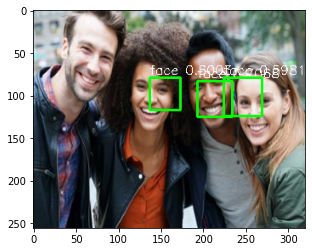

In [73]:
TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)
print("boxes:",boxes)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
print("pred_boxes:", pred_boxes)
print("labels:", labels)
print("scores:", scores)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)
# for gt_box_index in range(len(boxes)):
#     draw_gt_box_on_face(img_raw, boxes, gt_box_index)
plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

In [50]:
def draw_gt_box_on_face(img, boxes, classes, scores=None, box_index=None, class_list=None):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0])
    y_min = int(boxes[box_index][1])
    x_max = int(boxes[box_index][0] + boxes[box_index][2])
    y_max = int(boxes[box_index][1] + boxes[box_index][3])

    if classes[box_index] == 1:
        color = (0, 255, 255)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if scores:
        if len(scores) > box_index :
            score = "{:.4f}".format(scores[box_index])
            if class_list:
                class_name = class_list[classes[box_index]]
                label = '{} {}'.format(class_name, score)
                position = (x_min, y_min - 4) 
                cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))


### 60epoch 훈련시킨 SSD 모델

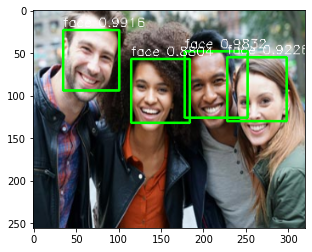

In [52]:

filepath = os.path.join(PROJECT_PATH, 'sgd_60epoch.h5')

model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
<class 'numpy.ndarray'> (256, 320, 3)
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
<class 'numpy.ndarray'> (256, 320, 3)
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 2

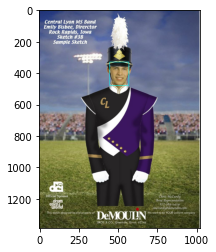

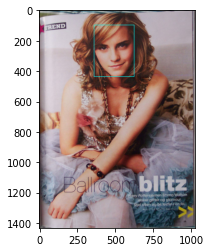

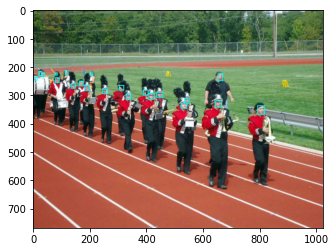

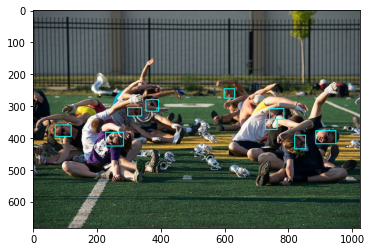

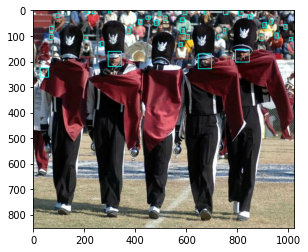

In [93]:
# train image 3장 gt 시각화하기
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)): # image file 단위의 gt annotation을 처리
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file) # tf.io로 파일경로로부터 불러오기
    
    gt_boxes = xywh_to_voc(image_file, info[1], image_data)
    img_raw = np.array(image_data) # numpy array 형변환
    print(gt_boxes)
    print(type(img), img.shape)
    
    #gt 박스 시각화하기
    fig, ax = plt.subplots(1,1)
    for j in range(len(info[1])):
        draw_gt_box_on_face(img_raw, info[1], gt_boxes['class'], scores=None, box_index=j, class_list=None) # 정답 박스를 시각화   
        
    plt.imshow(img_raw)
    
    
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
<class 'numpy.ndarray'> (256, 320, 3)
pred_boxes: [[0.42403576 0.2093068  0.5387725  0.35068473]
 [0.8967148  0.37843317 0.9430418  0.43633574]]
labels: [1 1]
scores: [0.5200123  0.50321037]


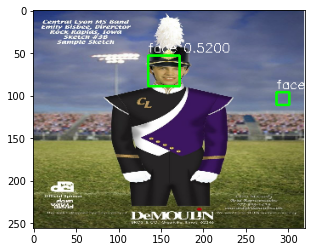

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
<class 'numpy.ndarray'> (256, 320, 3)
pred_boxes: [[0.36965618 0.10768023 0.6092485  0.42175075]
 [0.9021498  0.36165383 0.9470149  0.41824207]]
labels: [1 1]
scores: [0.7713071 0.5451665]


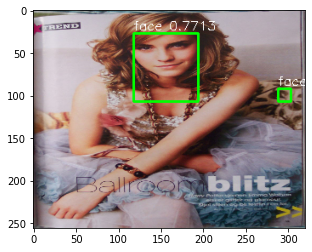

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 220, 232, 215], 'xmax': [85, 92, 124, 149, 177, 211, 197, 263, 320, 344, 406, 427, 458, 543, 666, 670, 816, 551, 40, 14, 32], 'ymax': [229, 255, 227, 275, 267, 230, 283, 294, 282, 315, 300, 314, 307, 346, 342, 249, 367, 328, 235, 247, 231], 'difficult': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
<class 'numpy.ndarray'> (256, 320, 3)
pred_boxes: [[0.43998358 0.4610651  0.45996615 0.48503453]
 [0.7287189  0.4056757  0.75883853 0.44073564]
 [0.6209253  0.41937366 0.64358675 0.4468263 ]
 [0.33639133 0.42323452 0.353

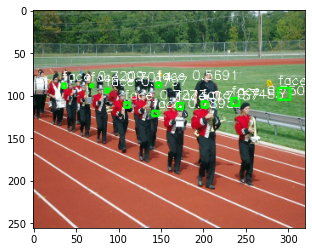

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_117.jpg', 'width': 1024, 'height': 682, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [69, 227, 296, 353, 885, 819, 727, 598, 740], 'ymin': [359, 382, 305, 280, 377, 391, 342, 246, 308], 'xmax': [119, 283, 340, 393, 948, 853, 764, 631, 785], 'ymax': [395, 425, 331, 316, 418, 434, 373, 275, 341], 'difficult': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
<class 'numpy.ndarray'> (256, 320, 3)
pred_boxes: [[0.7242973  0.446409   0.77419806 0.5103847 ]
 [0.40637028 0.4975613  0.4267273  0.52139765]
 [0.6360171  0.46679065 0.66105795 0.4994866 ]
 [0.18957485 0.44462734 0.21321414 0.476063  ]
 [0.90641963 0.3505744  0.9479797  0.40280905]
 [0.538903   0.47454342 0.5639117  0.5073633 ]
 [0.31818622 0.4654915  0.33829528 0.49122086]
 [0.18367235 0.52707916 0.20649792 0.55559236]]
labels: [1 1 1 1 1 1 1 1]
scores: [0.89252996 0.7306171  0.692607   0.6904527  0.62885565 0.622

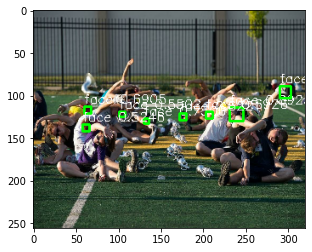

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_778.jpg', 'width': 1024, 'height': 852, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [27, 63, 64, 88, 231, 263, 367, 198, 293, 412, 441, 475, 510, 576, 577, 595, 570, 645, 719, 791, 884, 898, 945, 922, 743, 841, 980, 1001, 488, 586, 669, 744, 803, 294, 203], 'ymin': [226, 95, 63, 13, 1, 122, 68, 98, 161, 36, 23, 40, 23, 30, 71, 94, 126, 171, 98, 154, 97, 48, 89, 38, 71, 18, 56, 107, 2, 1, 1, 2, 3, 2, 0], 'xmax': [60, 79, 81, 104, 244, 277, 382, 213, 345, 426, 458, 489, 524, 592, 593, 611, 583, 697, 730, 845, 900, 913, 960, 937, 754, 857, 993, 1015, 500, 601, 681, 762, 821, 305, 216], 'ymax': [262, 114, 81, 28, 14, 142, 91, 116, 220, 56, 36, 61, 40, 45, 92, 114, 142, 229, 113, 203, 118, 69, 109, 54, 89, 34, 76, 120, 20, 18, 16, 17, 20, 12, 14], 'difficult': [0, 0, 0, 0, 0,

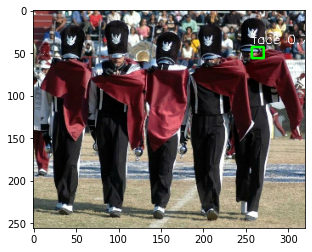

In [92]:
# train image 3장 pred 시각화하기
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)): # image file 단위의 gt annotation을 처리
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file) # tf.io로 파일경로로부터 불러오기
    
    gt_boxes = xywh_to_voc(image_file, info[1], image_data)
    img_raw = np.array(image_data) # numpy array 형변환
    print(gt_boxes)
    print(type(img), img.shape)
    
    # gt 박스 시각화하기
#     fig, ax = plt.subplots(1,1)
#     for j in range(len(info[1])):
#         draw_gt_box_on_face(img_raw, info[1], gt_boxes['class'], scores=None, box_index=j, class_list=None) # 정답 박스를 시각화   
        
#     plt.imshow(img_raw)
    
    
    # 예측 박스 시각화하기
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = img_raw.copy()

    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)
#     print("boxes:",boxes)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    print("pred_boxes:", pred_boxes)
    print("labels:", labels)
    print("scores:", scores)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)
    # for gt_box_index in range(len(boxes)):
    #     draw_gt_box_on_face(img_raw, boxes, gt_box_index)
    plt.imshow(img_raw)
    plt.show()

    
    
    if i > 3:
        break

### 60epoch 훈련시킨 ssd 모델

In [94]:
filepath = os.path.join(PROJECT_PATH, 'sgd_60epoch.h5')
model.load_weights(filepath)

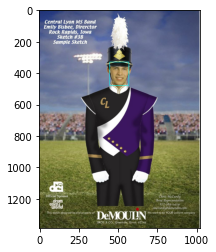

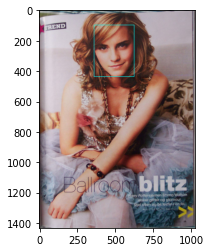

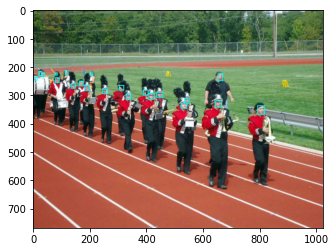

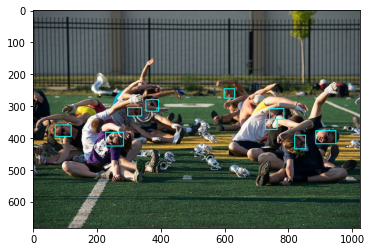

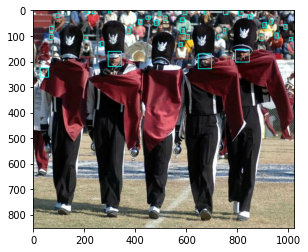

In [98]:
# train image 3장 gt 시각화하기
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)): # image file 단위의 gt annotation을 처리
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file) # tf.io로 파일경로로부터 불러오기
    
    gt_boxes = xywh_to_voc(image_file, info[1], image_data)
    img_raw = np.array(image_data) # numpy array 형변환
    #print(gt_boxes)
    #print(type(img), img.shape)
    
    #gt 박스 시각화하기
    fig, ax = plt.subplots(1,1)
    for j in range(len(info[1])):
        draw_gt_box_on_face(img_raw, info[1], gt_boxes['class'], scores=None, box_index=j, class_list=None) # 정답 박스를 시각화   
        
    plt.imshow(img_raw)
    
    
    if i > 3:
        break

In [85]:
# train image 3장 pred 시각화하기
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)): # image file 단위의 gt annotation을 처리
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file) # tf.io로 파일경로로부터 불러오기
    
    gt_boxes = xywh_to_voc(image_file, info[1], image_data)
    img_raw = np.array(image_data) # numpy array 형변환
    print(gt_boxes)
    print(type(img), img.shape)
    
    # gt 박스 시각화하기
#     fig, ax = plt.subplots(1,1)
#     for j in range(len(info[1])):
#         draw_gt_box_on_face(img_raw, info[1], gt_boxes['class'], scores=None, box_index=j, class_list=None) # 정답 박스를 시각화   
        
#     plt.imshow(img_raw)
    
    
    # 예측 박스 시각화하기
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = img_raw.copy()

    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)
#     print("boxes:",boxes)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    print("pred_boxes:", pred_boxes)
    print("labels:", labels)
    print("scores:", scores)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)
    # for gt_box_index in range(len(boxes)):
    #     draw_gt_box_on_face(img_raw, boxes, gt_box_index)
    plt.imshow(img_raw)
    plt.show()

    
    
    if i > 3:
        break

{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}


NameError: name 'img' is not defined

# [Face detector 활용] 스티커 사진 만들기

Step 1. 스티커 구하기 혹은 만들기
왕관 또는 고양이 수염 등을 구하거나 혹은 다양한 아이디어의 스티커를 만들어 볼 수 있을 것입니다.

Step 2. SSD 모델을 통해 얼굴 bounding box 찾기
우리는 실습 코드를 진행하며 필요한 모델을 이미 생성해 왔을 것입니다. 잘 훈련된 해당 모델을 통해 적절한 얼굴 bounding box를 찾아내 봅시다. inference.py 코드를 적극적으로 참고해 보시기를 권합니다.

Step 3. dlib 을 이용한 landmark 찾기 (선택사항)
붙이려는 이미지에 따라 face landmark를 찾아야 할 수도 있습니다. 검출된 bounding box에 dlib을 적용해 face landmark를 찾을 수 있을 것입니다.
dlib를 이용하려는 경우, inference.py 에서 show_image 메소드를 사용한 부분을 적절히 수정해야 가능할 것입니다.

Step 4. 스티커 합성 사진 생성하기
여러분들이 선택한 인물사진에 스티커를 합성해 봅시다. 이미지에 너무 많은 사람 얼굴이 포함되어 있거나, 검출된 얼굴이 너무 작아서 스티커 합성이 어울리지 않으면 적당하지 않겠죠? 3~5명 정도의 얼굴이 포함된 적당한 사진을 선택해 주세요.